## FFNN on formation energy

In [3]:
# import absl.logging
# absl.logging.set_verbosity(absl.logging.ERROR)

import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
import pickle

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.18.0


In [2]:
df= pd.read_excel("withDescriptors_DFT_D3_ACS_AMI_348_hetero_Ef_Eg.xlsx")

In [3]:
df_NN = df[['avg_vdw_radius', 'delta_a1a2_vdw_radius', 'delta_bx_vdw_radius', 'max_diff_vdw_radius', 'std_vdw_radius', 
           'avg_covalent_radius', 'delta_a1a2_covalent_radius', 'delta_bx_covalent_radius', 'max_diff_covalent_radius', 
           'std_covalent_radius', 'avg_atomic_radius', 'delta_a1a2_atomic_radius', 'delta_bx_atomic_radius', 'max_diff_atomic_radius', 
           'std_atomic_radius', 'avg_atomic_volume', 'delta_a1a2_atomic_volume', 'delta_bx_atomic_volume', 'max_diff_atomic_volume', 
           'std_atomic_volume', 'avg_dipole_polarizability', 'delta_a1a2_dipole_polarizability', 'delta_bx_dipole_polarizability', 
           'max_diff_dipole_polarizability', 'std_dipole_polarizability', 'avg_val_electrons', 'delta_a1a2_val_electrons', 
           'delta_bx_val_electrons', 'max_diff_val_electrons', 'std_val_electrons', 'avg_unp_electrons', 'delta_a1a2_unp_electrons',
           'delta_bx_unp_electrons', 'max_diff_unp_electrons', 'std_unp_electrons', 'avg_ion_energies', 'delta_a1a2_ion_energies', 
           'delta_bx_ion_energies', 'max_diff_ion_energies', 'std_ion_energies', 'avg_no_electrons', 'delta_a1a2_no_electrons', 
           'delta_bx_no_electrons', 'max_diff_no_electrons', 'std_no_electrons', 'avg_electronegativity', 'delta_a1a2_electronegativity',
           'delta_bx_electronegativity', 'max_diff_electronegativity', 'std_electronegativity', 'avg_electron_affinity', 
           'delta_a1a2_electron_affinity', 'delta_bx_electron_affinity', 'max_diff_electron_affinity', 'std_electron_affinity', 
            'Ef_per_cell', 'Mu_per_cell','bandgap']]

3/3 [==============================] - 0s 8ms/step


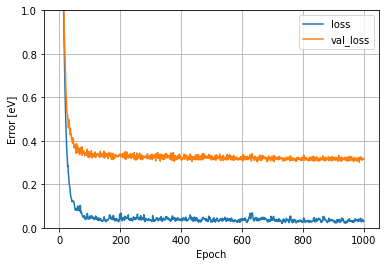

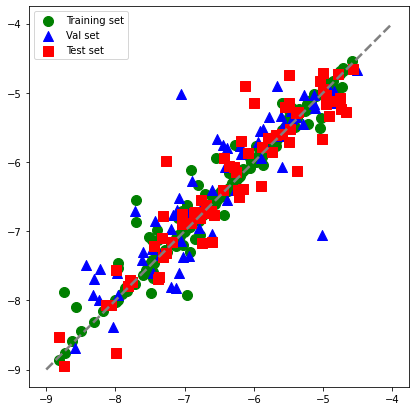

7/7 [==============================] - 0s 3ms/step
R-square score of training set: 0.956
3/3 [==============================] - 0s 8ms/step
R-square score of validation set: 0.740
3/3 [==============================] - 0s 0s/step
R-square score of test set: 0.870


7/7 [==============================] - 0s 3ms/step
MAE of training set: 0.101
3/3 [==============================] - 0s 0s/step
MAE of validation set: 0.365
3/3 [==============================] - 0s 0s/step
MAE of test set: 0.273


In [255]:
train_val_dataset = df_NN.sample(frac = 0.8, random_state = 42)
train_dataset = train_val_dataset.sample(frac = 0.75, random_state = 42)
val_dataset = train_val_dataset.drop(train_dataset.index)
test_dataset = df_NN.drop(train_val_dataset.index)

train_data = np.copy(train_dataset)
val_data = np.copy(val_dataset)
test_data = np.copy(test_dataset)

train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)

X_train = train_data.drop([55,56,57],axis='columns')
X_val = val_data.drop([55,56,57],axis='columns')
X_test = test_data.drop([55,56,57],axis='columns')

y_train = train_data.drop([i for i in range(55)],axis='columns')
y_val = val_data.drop([i for i in range(55)],axis='columns')
y_test = test_data.drop([i for i in range(55)],axis='columns')

X_ef_train = np.copy(X_train)
X_ef_val = np.copy(X_val)
X_ef_test = np.copy(X_test)

y_ef_train = y_train.drop([56,57],axis='columns')
y_ef_val = y_val.drop([56,57],axis='columns')
y_ef_test = y_test.drop([56,57],axis='columns')

def build_and_compile_model(norm):
    model=tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(55, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='mean_absolute_error')
    
    return model

normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(X_ef_train))

dnn_ef = build_and_compile_model(normalizer)

history_ef=dnn_ef.fit(x=X_ef_train, y=y_ef_train, validation_split=0.25,verbose=0, epochs=1000)

hist_ef = pd.DataFrame(history_ef.history)
hist_ef['epoch'] = history_ef.epoch
hist_ef.tail()

def plot_loss(history):
    plt.plot(history_ef.history['loss'], label='loss')
    plt.plot(history_ef.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [eV]')
    plt.legend()
    plt.grid(True)

plot_loss(history_ef)

plt.figure(figsize=(7,7))
train_ef_predict = dnn_ef.predict(X_ef_train).flatten()
val_ef_predict = dnn_ef.predict(X_ef_val).flatten()
test_ef_predict = dnn_ef.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_predict, color='green', s=100, marker='o', label='Training set' )
plt.scatter(y_ef_val, val_ef_predict, color='blue',s=100, marker='^', label='Val set')
plt.scatter(y_ef_test, test_ef_predict, color='red',s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

from sklearn import metrics

print('R-square score of training set: {:0.3f}'.format((metrics.r2_score(y_ef_train, dnn_ef.predict(X_ef_train)))))
print('R-square score of validation set: {:0.3f}'.format((metrics.r2_score(y_ef_val, dnn_ef.predict(X_ef_val)))))
print('R-square score of test set: {:0.3f}'.format(metrics.r2_score(y_ef_test, dnn_ef.predict(X_ef_test))))
print('\n')
print('MAE of training set: {:0.3f}'.format((metrics.mean_absolute_error(y_ef_train, dnn_ef.predict(X_ef_train)))))
print('MAE of validation set: {:0.3f}'.format((metrics.mean_absolute_error(y_ef_val, dnn_ef.predict(X_ef_val)))))
print('MAE of test set: {:0.3f}'.format(metrics.mean_absolute_error(y_ef_test, dnn_ef.predict(X_ef_test))))

3/3 [==============================] - 0s 4ms/step


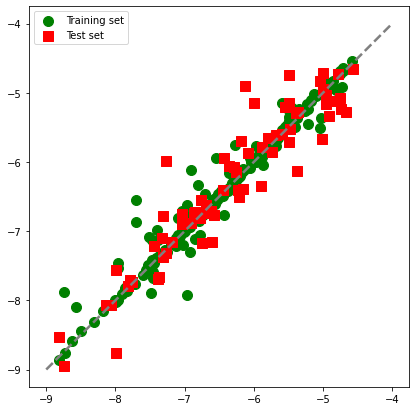

In [271]:
plt.figure(figsize=(7,7))
train_ef_predict = dnn_ef.predict(X_ef_train).flatten()
#val_ef_predict = dnn_ef.predict(X_ef_val).flatten()
test_ef_predict = dnn_ef.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_predict, color='green', s=100, marker='o', label='Training set' )
#plt.scatter(y_ef_val, val_ef_predict, color='blue',s=100, marker='^', label='Val set')
plt.scatter(y_ef_test, test_ef_predict, color='red',s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

In [270]:
pd.DataFrame(X_train.to_csv('Results_Ef/X_train_FFNN.csv',index=False))
pd.DataFrame(X_val.to_csv('Results_Ef/X_val_FFNN.csv',index=False))
pd.DataFrame(X_test.to_csv('Results_Ef/X_test_FFNN.csv',index=False))
pd.DataFrame(y_train.to_csv('Results_Ef/y_train_FFNN.csv',index=False))
pd.DataFrame(y_val.to_csv('Results_Ef/y_val_FFNN.csv',index=False))
pd.DataFrame(y_test.to_csv('Results_Ef/y_test_FFNN.csv',index=False))

Empty DataFrame
Columns: []
Index: []

In [268]:
dnn_ef.save('Results_Ef/saved_FFNN_Ef')

with open("Results_Ef/FFNN_Ef.pkl", 'wb') as f:
    pickle.dump(history_ef.history, f)

INFO:tensorflow:Assets written to: FFNN_Ef/saved_FFNN_Ef\assets


INFO:tensorflow:Assets written to: FFNN_Ef/saved_FFNN_Ef\assets


In [269]:
train_ef_predict_pd = pd.DataFrame(train_ef_predict)
val_ef_predict_pd = pd.DataFrame(val_ef_predict)
test_ef_predict_pd = pd.DataFrame(test_ef_predict)

train_ef_predict_pd.to_csv('Results_Ef/y_pred_train_ef_FFNN.csv',index=False)
val_ef_predict_pd.to_csv('Results_Ef/y_pred_val_ef_FFNN.csv',index=False)
test_ef_predict_pd.to_csv('Results_Ef/y_pred_test_ef_FFNN.csv',index=False)

In [172]:
## Dropout

In [276]:
def build_and_compile_dropout_model(norm):
    model_dropout=tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(55, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1)
    ])
    
    model_dropout.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='mean_absolute_error')
    
    return model_dropout

In [277]:
dnn_ef_dropout = build_and_compile_dropout_model(normalizer)

In [278]:
%%time
history_ef_dropout=dnn_ef_dropout.fit(x=X_ef_train, y=y_ef_train, validation_split=0.25,verbose=0, epochs=1000)

hist_ef_dropout = pd.DataFrame(history_ef_dropout.history)
hist_ef_dropout['epoch'] = history_ef_dropout.epoch
hist_ef_dropout.tail()

Wall time: 31 s


loss  val_loss  epoch
995  0.393350  0.268321    995
996  0.419407  0.335390    996
997  0.338371  0.276179    997
998  0.384199  0.250962    998
999  0.400875  0.257597    999

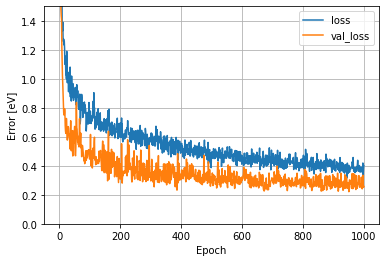

In [279]:
def plot_loss(history_ef):
    plt.plot(history_ef.history['loss'], label='loss')
    plt.plot(history_ef.history['val_loss'], label='val_loss')
    plt.ylim([0, 1.5])
    plt.xlabel('Epoch')
    plt.ylabel('Error [eV]')
    plt.legend()
    plt.grid(True)

plot_loss(history_ef_dropout)

3/3 [==============================] - 0s 8ms/step


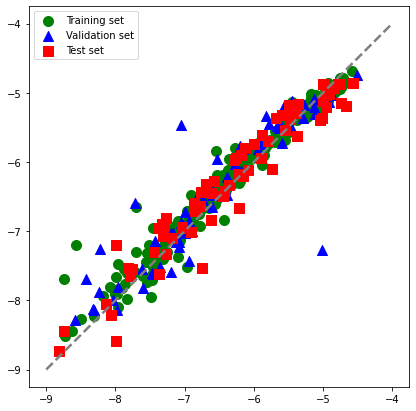

In [280]:
plt.figure(figsize=(7,7))
train_ef_dropout_predict = dnn_ef_dropout.predict(X_ef_train).flatten()
val_ef_dropout_predict = dnn_ef_dropout.predict(X_ef_val).flatten()
test_ef_dropout_predict = dnn_ef_dropout.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_dropout_predict, color='green', s=100, marker='o', label='Training set')
plt.scatter(y_ef_val, val_ef_dropout_predict, color='blue', s=100, marker='^', label='Validation set')
plt.scatter(y_ef_test, test_ef_dropout_predict, color='red', s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

3/3 [==============================] - 0s 1ms/step


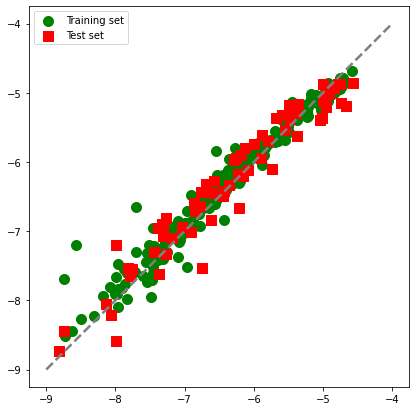

In [282]:
plt.figure(figsize=(7,7))
train_ef_dropout_predict = dnn_ef_dropout.predict(X_ef_train).flatten()
#val_ef_dropout_predict = dnn_ef_dropout.predict(X_ef_val).flatten()
test_ef_dropout_predict = dnn_ef_dropout.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_dropout_predict, color='green', s=100, marker='o', label='Training set')
#plt.scatter(y_ef_val, val_ef_dropout_predict, color='blue', s=100, marker='^', label='Validation set')
plt.scatter(y_ef_test, test_ef_dropout_predict, color='red', s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

In [281]:
print('MAE of training set: {:0.3f}'.format(dnn_ef_dropout.evaluate(X_ef_train, y_ef_train, verbose=0)))
print('MAE of validation set: {:0.3f}'.format(dnn_ef_dropout.evaluate(X_ef_val, y_ef_val, verbose=0)))
print('MAE of test set: {:0.3f}'.format(dnn_ef_dropout.evaluate(X_ef_test, y_ef_test, verbose=0)))
print('\n')

print('R-square score of training set: {:0.3f}'.format((metrics.r2_score(y_ef_train, dnn_ef_dropout.predict(X_ef_train)))))
print('R-square score of validation set: {:0.3f}'.format((metrics.r2_score(y_ef_val, dnn_ef_dropout.predict(X_ef_val)))))
print('R-square score of test set: {:0.3f}'.format(metrics.r2_score(y_ef_test, dnn_ef_dropout.predict(X_ef_test))))

MAE of training set: 0.146
MAE of validation set: 0.265
MAE of test set: 0.233


7/7 [==============================] - 0s 3ms/step
R-square score of training set: 0.948
3/3 [==============================] - 0s 1ms/step
R-square score of validation set: 0.813
3/3 [==============================] - 0s 7ms/step
R-square score of test set: 0.928


In [301]:
dnn_ef_dropout.save('Results_Ef/saved_FFNN_dropout_Ef')

with open("Results_Ef/FFNN_dropout_Ef.pkl", 'wb') as f:
    pickle.dump(history_ef_dropout.history, f)

INFO:tensorflow:Assets written to: Results_Ef/saved_FFNN_dropout_Ef\assets


INFO:tensorflow:Assets written to: Results_Ef/saved_FFNN_dropout_Ef\assets


In [304]:
train_ef_predict_dropout_pd = pd.DataFrame(train_ef_dropout_predict)
val_ef_predict_dropout_pd = pd.DataFrame(val_ef_dropout_predict)
test_ef_predict_dropout_pd = pd.DataFrame(test_ef_dropout_predict)

train_ef_predict_dropout_pd.to_csv('Results_Ef/y_pred_train_ef_FFNN_dropout.csv',index=False)
val_ef_predict_dropout_pd.to_csv('Results_Ef/y_pred_val_ef_FFNN_dropout.csv',index=False)
test_ef_predict_dropout_pd.to_csv('Results_Ef/y_pred_test_ef_FFNN_dropout.csv',index=False)

In [179]:
## L1 regularization

In [283]:
def build_and_compile_L1_model(norm):
    model_L1=tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(55, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
        tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
        tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
        tf.keras.layers.Dense(1)
    ])
    
    model_L1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='mean_absolute_error')
    
    return model_L1

In [284]:
dnn_ef_L1 = build_and_compile_L1_model(normalizer)

In [285]:
%%time
history_ef_L1=dnn_ef_L1.fit(x=X_ef_train, y=y_ef_train, validation_split=0.25,verbose=0, epochs=1000)

hist_ef_L1 = pd.DataFrame(history_ef_L1.history)
hist_ef_L1['epoch'] = history_ef_L1.epoch
hist_ef_L1.tail()

Wall time: 30.5 s


loss  val_loss  epoch
995  0.099367  0.331647    995
996  0.086121  0.333163    996
997  0.086246  0.333201    997
998  0.078532  0.327637    998
999  0.080001  0.336773    999

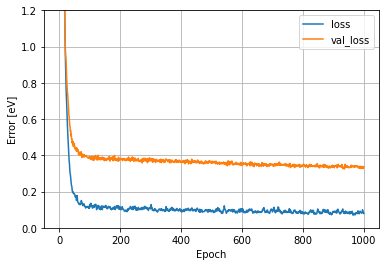

In [286]:
def plot_loss(history_ef):
    plt.plot(history_ef.history['loss'], label='loss')
    plt.plot(history_ef.history['val_loss'], label='val_loss')
    plt.ylim([0, 1.2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [eV]')
    plt.legend()
    plt.grid(True)

plot_loss(history_ef_L1)

In [287]:
# hist_ef_L1.to_csv('formation_energy_training_history_L1.csv',index=False)

3/3 [==============================] - 0s 5ms/step


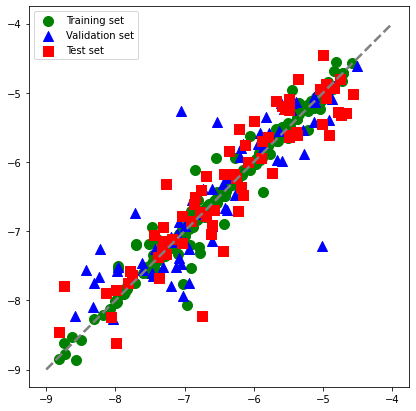

In [288]:
plt.figure(figsize=(7,7))
train_ef_L1_predict = dnn_ef_L1.predict(X_ef_train).flatten()
val_ef_L1_predict = dnn_ef_L1.predict(X_ef_val).flatten()
test_ef_L1_predict = dnn_ef_L1.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_L1_predict, color='green', s=100, marker='o', label='Training set')
plt.scatter(y_ef_val, val_ef_L1_predict, color='blue', s=100, marker='^', label='Validation set')
plt.scatter(y_ef_test, test_ef_L1_predict, color='red', s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

3/3 [==============================] - 0s 6ms/step


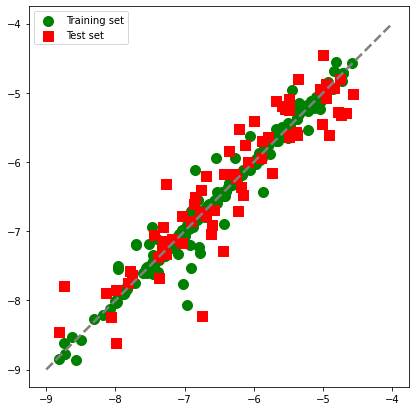

In [290]:
plt.figure(figsize=(7,7))
train_ef_L1_predict = dnn_ef_L1.predict(X_ef_train).flatten()
#val_ef_L1_predict = dnn_ef_L1.predict(X_ef_val).flatten()
test_ef_L1_predict = dnn_ef_L1.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_L1_predict, color='green', s=100, marker='o', label='Training set')
#plt.scatter(y_ef_val, val_ef_L1_predict, color='blue', s=100, marker='^', label='Validation set')
plt.scatter(y_ef_test, test_ef_L1_predict, color='red', s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

In [289]:
print('MAE of training set: {:0.3f}'.format(dnn_ef_L1.evaluate(X_ef_train, y_ef_train, verbose=0)))
print('MAE of val set: {:0.3f}'.format(dnn_ef_L1.evaluate(X_ef_val, y_ef_val, verbose=0)))
print('MAE of test set: {:0.3f}'.format(dnn_ef_L1.evaluate(X_ef_test, y_ef_test, verbose=0)))
print('\n')

print('R-square score of training set: {:0.3f}'.format((metrics.r2_score(y_ef_train, dnn_ef_L1.predict(X_ef_train)))))
print('R-square score of val set: {:0.3f}'.format(metrics.r2_score(y_ef_val, dnn_ef_L1.predict(X_ef_val))))
print('R-square score of test set: {:0.3f}'.format(metrics.r2_score(y_ef_test, dnn_ef_L1.predict(X_ef_test))))

MAE of training set: 0.144
MAE of val set: 0.418
MAE of test set: 0.370


7/7 [==============================] - 0s 0s/step
R-square score of training set: 0.964
3/3 [==============================] - 0s 3ms/step
R-square score of val set: 0.738
3/3 [==============================] - 0s 2ms/step
R-square score of test set: 0.846


In [299]:
dnn_ef_L1.save('Results_Ef/saved_FFNN_L1_Ef')

with open("Results_Ef/FFNN_L1_Ef.pkl", 'wb') as f:
    pickle.dump(history_ef_L1.history, f)

INFO:tensorflow:Assets written to: Results_Ef/saved_FFNN_L1_Ef\assets


INFO:tensorflow:Assets written to: Results_Ef/saved_FFNN_L1_Ef\assets


In [303]:
train_ef_predict_L1_pd = pd.DataFrame(train_ef_L1_predict)
val_ef_predict_L1_pd = pd.DataFrame(val_ef_L1_predict)
test_ef_predict_L1_pd = pd.DataFrame(test_ef_L1_predict)

train_ef_predict_L1_pd.to_csv('Results_Ef/y_pred_train_ef_FFNN_L1.csv',index=False)
val_ef_predict_L1_pd.to_csv('Results_Ef/y_pred_val_ef_FFNN_L1.csv',index=False)
test_ef_predict_L1_pd.to_csv('Results_Ef/y_pred_test_ef_FFNN_L1.csv',index=False)

In [189]:
## L2 regularization

In [291]:
def build_and_compile_L2_model(norm):
    model_L2=tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(55, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dense(1)
    ])
    
    model_L2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='mean_absolute_error')
    
    return model_L2

In [292]:
dnn_ef_L2 = build_and_compile_L2_model(normalizer)

In [293]:
%%time
history_ef_L2=dnn_ef_L2.fit(x=X_ef_train, y=y_ef_train, validation_split=0.25,verbose=0, epochs=1000)

hist_ef_L2 = pd.DataFrame(history_ef_L2.history)
hist_ef_L2['epoch'] = history_ef_L2.epoch
hist_ef_L2.tail()

Wall time: 31.4 s


loss  val_loss  epoch
995  0.045451  0.315816    995
996  0.043576  0.298717    996
997  0.047849  0.292163    997
998  0.055863  0.288837    998
999  0.042190  0.298264    999

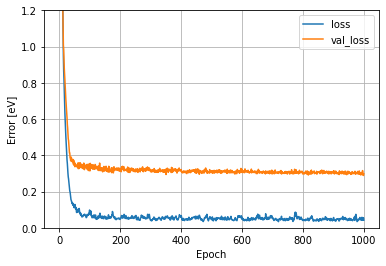

In [294]:
def plot_loss(history_ef):
    plt.plot(history_ef.history['loss'], label='loss')
    plt.plot(history_ef.history['val_loss'], label='val_loss')
    plt.ylim([0, 1.2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [eV]')
    plt.legend()
    plt.grid(True)

plot_loss(history_ef_L2)

In [295]:
# hist_ef_L2.to_csv('formation_energy_training_history_L2.csv',index=False)

3/3 [==============================] - 0s 2ms/step


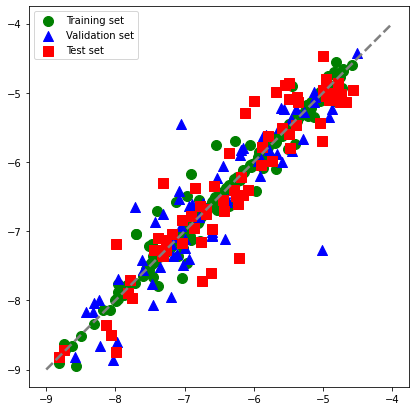

In [296]:
plt.figure(figsize=(7,7))
train_ef_L2_predict = dnn_ef_L2.predict(X_ef_train).flatten()
val_ef_L2_predict = dnn_ef_L2.predict(X_ef_val).flatten()
test_ef_L2_predict = dnn_ef_L2.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_L2_predict, color='green', s=100, marker='o', label='Training set')
plt.scatter(y_ef_val, val_ef_L2_predict, color='blue', s=100, marker='^', label='Validation set')
plt.scatter(y_ef_test, test_ef_L2_predict, color='red', s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

3/3 [==============================] - 0s 9ms/step


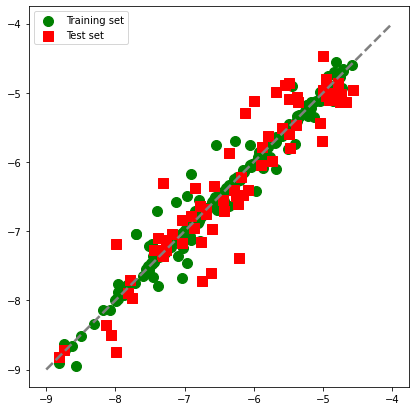

In [298]:
plt.figure(figsize=(7,7))
train_ef_L2_predict = dnn_ef_L2.predict(X_ef_train).flatten()
#val_ef_L2_predict = dnn_ef_L2.predict(X_ef_val).flatten()
test_ef_L2_predict = dnn_ef_L2.predict(X_ef_test).flatten()
plt.axes(aspect='equal')
plt.scatter(y_ef_train, train_ef_L2_predict, color='green', s=100, marker='o', label='Training set')
#plt.scatter(y_ef_val, val_ef_L2_predict, color='blue', s=100, marker='^', label='Validation set')
plt.scatter(y_ef_test, test_ef_L2_predict, color='red', s=100, marker='s', label='Test set')

plt.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

In [297]:
print('MAE of training set: {:0.3f}'.format(dnn_ef_L2.evaluate(X_ef_train, y_ef_train, verbose=0)))
print('MAE of val set: {:0.3f}'.format(dnn_ef_L2.evaluate(X_ef_val, y_ef_val, verbose=0)))
print('MAE of test set: {:0.3f}'.format(dnn_ef_L2.evaluate(X_ef_test, y_ef_test, verbose=0)))
print('\n')

print('R-square score of training set: {:0.3f}'.format((metrics.r2_score(y_ef_train, dnn_ef_L2.predict(X_ef_train)))))
print('R-square score of val set: {:0.3f}'.format(metrics.r2_score(y_ef_val, dnn_ef_L2.predict(X_ef_val))))
print('R-square score of test set: {:0.3f}'.format(metrics.r2_score(y_ef_test, dnn_ef_L2.predict(X_ef_test))))

MAE of training set: 0.101
MAE of val set: 0.356
MAE of test set: 0.324


7/7 [==============================] - 0s 3ms/step
R-square score of training set: 0.966
3/3 [==============================] - 0s 10ms/step
R-square score of val set: 0.768
3/3 [==============================] - 0s 7ms/step
R-square score of test set: 0.843


In [300]:
dnn_ef_L2.save('Results_Ef/saved_FFNN_L2_Ef')

with open("Results_Ef/FFNN_L2_Ef.pkl", 'wb') as f:
    pickle.dump(history_ef_L2.history, f)

INFO:tensorflow:Assets written to: Results_Ef/saved_FFNN_L2_Ef\assets


INFO:tensorflow:Assets written to: Results_Ef/saved_FFNN_L2_Ef\assets


In [302]:
train_ef_predict_L2_pd = pd.DataFrame(train_ef_L2_predict)
val_ef_predict_L2_pd = pd.DataFrame(val_ef_L2_predict)
test_ef_predict_L2_pd = pd.DataFrame(test_ef_L2_predict)

train_ef_predict_L2_pd.to_csv('Results_Ef/y_pred_train_ef_FFNN_L2.csv',index=False)
val_ef_predict_L2_pd.to_csv('Results_Ef/y_pred_val_ef_FFNN_L2.csv',index=False)
test_ef_predict_L2_pd.to_csv('Results_Ef/y_pred_test_ef_FFNN_L2.csv',index=False)

## Using Optuna to tune the hyperparameters in FFNN

In [7]:
X_ef_train = pd.read_csv('Results_Ef/X_train_FFNN.csv')
X_ef_val = pd.read_csv('Results_Ef/X_val_FFNN.csv')
X_ef_test = pd.read_csv('Results_Ef/X_test_FFNN.csv')

y_train = pd.read_csv('Results_Ef/y_train_FFNN.csv')
y_val = pd.read_csv('Results_Ef/y_val_FFNN.csv')
y_test = pd.read_csv('Results_Ef/y_test_FFNN.csv')

y_ef_train = y_train['55']
y_ef_val = y_val['55']
y_ef_test = y_test['55']

In [12]:
import tensorflow as tf
import optuna
import numpy as np
from tensorflow.keras import layers, regularizers
from sklearn.metrics import r2_score
import random

def objective(trial):

    hidden_layer_1  = trial.suggest_categorical('hidden_1', [55, 64])
    hidden_layer_2 = trial.suggest_categorical('hidden_2', [128, 32, 30])
    hidden_layer_3 = trial.suggest_categorical('hidden_3', [64, 20, 16])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.0, 0.1, 0.2])
    reg_type = trial.suggest_categorical('reg_type', ['None', 'L1', 'L2'])
    reg_strength = trial.suggest_categorical('reg_strength', [1e-5, 1e-4, 1e-3, 1e-2]) if reg_type != 'None' else 0.0
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 5e-3, 1e-2])
    activation_type = trial.suggest_categorical('activation', ['relu', 'elu', 'selu'])

    SEED = 42
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_ef_train))
    
    if reg_type == 'L1':
        reg = regularizers.l1(reg_strength)
    elif reg_type == 'L2':
        reg = regularizers.l2(reg_strength)
    else:
        reg = None  # No regularization  

    model = tf.keras.Sequential([normalizer])

    model.add(layers.Dense(hidden_layer_1, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(hidden_layer_2, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(hidden_layer_3, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(1))  

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_absolute_error')

    # Train model
    history = model.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

    # Return best validation loss
    # return min(history.history['val_loss'])

    # Return best R2 scores
    r2_train = r2_score(y_ef_train, model.predict(X_ef_train).flatten())
    r2_val = r2_score(y_ef_val, model.predict(X_ef_val).flatten())
    r2_test = r2_score(y_ef_test, model.predict(X_ef_test).flatten())
    return r2_train,r2_val,r2_test

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study = optuna.create_study(directions=['maximize','maximize','maximize']) # for maximizing R2
study.optimize(objective, n_trials=300)

# Print best hyperparameters
#print("Best hyperparameters:", study.best_params)
#print("Best R² score:", study.best_value)

[I 2025-02-26 21:28:53,616] A new study created in memory with name: no-name-b410fa21-4331-41be-b6d4-626f656a8694


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 21:29:16,870] Trial 0 finished with values: [0.9673436091051498, 0.8045656704922024, 0.9140879592103615] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 21:29:38,235] Trial 1 finished with values: [0.9111778736427939, 0.7974473925365677, 0.9097064779090313] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:30:01,137] Trial 2 finished with values: [0.9384812106669634, 0.8014613764149487, 0.944596521778009] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:30:23,531] Trial 3 finished with values: [0.9933569479834742, 0.8420913044667905, 0.9460702419484247] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:30:45,206] Trial 4 finished with values: [0.9769675882355712, 0.8420781376782498, 0.9369747919256344] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:31:07,252] Trial 5 finished with values: [0.9966925109399464, 0.8470853063426148, 0.967500069611453] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:31:30,062] Trial 6 finished with values: [0.9366178774538302, 0.822877710455434, 0.9017031574973047] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:31:51,925] Trial 7 finished with values: [0.9934482992525957, 0.8450820415769023, 0.9294332947915253] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:32:14,752] Trial 8 finished with values: [0.9882843348782397, 0.8048866949386373, 0.9542015530093657] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:32:36,955] Trial 9 finished with values: [0.9327156484609143, 0.8055177347773885, 0.9309405446248066] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:32:59,057] Trial 10 finished with values: [0.983801040783899, 0.8155932118262443, 0.9619085850276937] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:33:17,858] Trial 11 finished with values: [0.9392918698729117, 0.810376720467312, 0.9270801708418115] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:33:39,678] Trial 12 finished with values: [0.9401336770197022, 0.7942696250040893, 0.9466309873497745] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 1ms/step


[I 2025-02-26 21:34:02,714] Trial 13 finished with values: [0.8858222498398336, 0.7670191833683752, 0.897791676809849] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:34:24,975] Trial 14 finished with values: [0.9802920404096895, 0.7992081684682696, 0.9053582895254191] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:34:48,064] Trial 15 finished with values: [0.9502831956005409, 0.8159644137339984, 0.9122999086706374] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:35:12,300] Trial 16 finished with values: [0.9773942006881415, 0.8215423528020842, 0.9329650178726222] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:35:34,252] Trial 17 finished with values: [0.949537466228094, 0.8163774620452725, 0.9403811070625048] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:35:55,498] Trial 18 finished with values: [0.666695144319582, 0.4413067161093517, 0.5557985967800996] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:36:14,419] Trial 19 finished with values: [0.5471121869397686, 0.26959139838225565, 0.49806137926625127] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:36:34,672] Trial 20 finished with values: [0.9910515733304412, 0.8462859177423292, 0.9079661679703428] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:36:56,185] Trial 21 finished with values: [0.9673436091051498, 0.8045656704922024, 0.9140879592103615] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:37:17,976] Trial 22 finished with values: [0.9789175755386437, 0.8295396216302952, 0.9574816498024799] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:37:40,277] Trial 23 finished with values: [0.9421942255588418, 0.7908195885305298, 0.9339804740730777] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 1ms/step


[I 2025-02-26 21:38:03,978] Trial 24 finished with values: [0.8834519891089723, 0.7613219223786793, 0.8966265917002423] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:38:27,499] Trial 25 finished with values: [0.8966258455600464, 0.7880706552543046, 0.9078700046763521] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:38:51,625] Trial 26 finished with values: [0.9356031408111444, 0.7993355467565838, 0.9059419857797226] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:39:14,027] Trial 27 finished with values: [0.9966767102533994, 0.8579782824913061, 0.9542830985532621] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:39:35,844] Trial 28 finished with values: [0.9111121243694459, 0.7963029985467182, 0.9020425319287233] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:39:57,920] Trial 29 finished with values: [0.9639189515555423, 0.8072836568210655, 0.9217479500107519] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:40:19,542] Trial 30 finished with values: [0.965703889020324, 0.8331808866007403, 0.9218474028290253] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:40:41,286] Trial 31 finished with values: [0.9436874789175204, 0.8124673555521831, 0.9475922057916427] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:41:04,197] Trial 32 finished with values: [0.9398532448799718, 0.7907439931821136, 0.9221738442732843] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:41:25,746] Trial 33 finished with values: [0.8610441049102564, 0.6613907210483021, 0.743935488547578] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:41:46,932] Trial 34 finished with values: [0.9822800041287099, 0.7994849029708236, 0.9486986407556426] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:42:08,212] Trial 35 finished with values: [0.9668592358089939, 0.7653455244363524, 0.8816658643632508] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:42:29,157] Trial 36 finished with values: [0.9674413668957601, 0.771967657168827, 0.8946170708115745] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:42:50,757] Trial 37 finished with values: [0.9512597306067913, 0.8333589455741061, 0.9506230321747158] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:43:12,012] Trial 38 finished with values: [0.9859040987236622, 0.8381591468456424, 0.9239956195043688] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:43:33,465] Trial 39 finished with values: [0.9754127327304563, 0.83110820809534, 0.9351892633611986] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:43:54,945] Trial 40 finished with values: [0.9144135569443369, 0.8054148245478343, 0.9087917018211589] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 1ms/step


[I 2025-02-26 21:44:15,348] Trial 41 finished with values: [0.9938786427484465, 0.8205464838837992, 0.9404456764383334] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:44:37,432] Trial 42 finished with values: [0.9066922325806439, 0.7789305803787111, 0.9159134344350597] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:44:59,939] Trial 43 finished with values: [0.8425082082485198, 0.7216463615090933, 0.8534681740857931] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:45:22,085] Trial 44 finished with values: [0.9052694622764078, 0.7928989510075918, 0.8912427378493635] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:45:44,195] Trial 45 finished with values: [0.9574204683922827, 0.8268846723466161, 0.9472632629548751] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 21:46:07,194] Trial 46 finished with values: [0.97882773054332, 0.8161924530706334, 0.944416741741521] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:46:29,394] Trial 47 finished with values: [0.8424394823196886, 0.7133313857593397, 0.8272269702587561] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:46:53,476] Trial 48 finished with values: [0.9506433549073066, 0.7619761514863974, 0.9090083833904999] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:47:19,365] Trial 49 finished with values: [0.9321698291129139, 0.8163372376978022, 0.902403081080547] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 21:47:43,466] Trial 50 finished with values: [0.9785481351284422, 0.8405764702804591, 0.9506687818819259] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:48:07,646] Trial 51 finished with values: [0.9371746151103986, 0.7851022542304277, 0.924984037008995] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 21:48:29,293] Trial 52 finished with values: [0.9890620032999922, 0.8624842584415094, 0.9602584159493425] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:48:50,742] Trial 53 finished with values: [0.9962210352641495, 0.6804826093446719, 0.815986472081689] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 21:49:13,976] Trial 54 finished with values: [0.9829926469834497, 0.8181610501243533, 0.9523819572213138] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 21:49:36,792] Trial 55 finished with values: [0.9583625097152764, 0.8297638486741077, 0.9447229392468296] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 21:50:00,119] Trial 56 finished with values: [0.990397239128033, 0.8307859029670416, 0.959323296879498] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 21:50:22,616] Trial 57 finished with values: [0.8622568727497022, 0.7529221258220589, 0.891668747452482] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 21:50:46,324] Trial 58 finished with values: [0.9309023675116639, 0.7783717298310648, 0.9355360733590941] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 21:51:11,972] Trial 59 finished with values: [0.7201592041560108, 0.5947284633637595, 0.7600377628537777] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 21:51:36,853] Trial 60 finished with values: [0.9725160032911285, 0.8215033354836232, 0.941439746289189] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:51:58,910] Trial 61 finished with values: [0.9746954781086349, 0.84069245387851, 0.9502424344606296] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:52:19,609] Trial 62 finished with values: [0.9475572102220376, 0.7961416654933542, 0.9355763205600208] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:52:38,333] Trial 63 finished with values: [0.988373244553309, 0.8398305660689416, 0.889618719927612] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 21:52:58,632] Trial 64 finished with values: [0.9786163936634418, 0.8291961980780174, 0.9558990333824052] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:53:19,353] Trial 65 finished with values: [0.8937155548091195, 0.7543242295226624, 0.913470300130086] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:53:37,513] Trial 66 finished with values: [0.9776907511527902, 0.840418032390696, 0.9316248547381684] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:53:57,337] Trial 67 finished with values: [0.955026145964098, 0.8243544825236138, 0.9403690344401956] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:54:20,180] Trial 68 finished with values: [0.9364738082787231, 0.7820650310859135, 0.9327993711525495] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:54:43,090] Trial 69 finished with values: [0.9094582154409587, 0.7717710227174683, 0.9139887777986204] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:55:05,095] Trial 70 finished with values: [0.9907022201663767, 0.7907393806285996, 0.9704581826858213] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:55:27,963] Trial 71 finished with values: [0.9098159758871538, 0.7514761335927989, 0.9051279018920556] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 21:55:49,006] Trial 72 finished with values: [0.9383920912699152, 0.7961233170691107, 0.931527542075519] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 21:56:07,275] Trial 73 finished with values: [0.972628522177945, 0.8408519187336353, 0.977030494097975] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:56:26,496] Trial 74 finished with values: [0.9938268191558203, 0.854163255836534, 0.9566096968820192] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:56:46,591] Trial 75 finished with values: [0.9949630328503445, 0.6999769681192163, 0.7554419903669438] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 21:57:06,261] Trial 76 finished with values: [0.984620499492506, 0.8538877363975366, 0.9629344930757355] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:57:25,755] Trial 77 finished with values: [0.9972984310031251, 0.8341727069359853, 0.9733379143773068] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:57:46,430] Trial 78 finished with values: [0.9815058799927446, 0.7802130363440062, 0.8774115054167686] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 21:58:06,648] Trial 79 finished with values: [0.9538328622022658, 0.8298090010057148, 0.9357894032892204] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 21:58:26,798] Trial 80 finished with values: [0.9668518747802247, 0.8101556373128347, 0.9327091741922462] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 21:58:46,454] Trial 81 finished with values: [0.9925176524748501, 0.8144076099841028, 0.9578796536707453] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 21:59:05,827] Trial 82 finished with values: [0.9397283933794387, 0.8125895358812134, 0.9276144290008215] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:59:24,630] Trial 83 finished with values: [0.9875270849083216, 0.8189604463537976, 0.9403923626527895] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 21:59:43,863] Trial 84 finished with values: [0.913249321472259, 0.7983767488473933, 0.9004803021280262] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:00:04,043] Trial 85 finished with values: [0.9848738899854534, 0.8214314582394702, 0.9494543467359505] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:00:22,852] Trial 86 finished with values: [0.9733912503013055, 0.8403919389230836, 0.9694768013006387] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:00:41,466] Trial 87 finished with values: [0.9807810785398455, 0.7574755340021897, 0.8251227242630551] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:01:01,183] Trial 88 finished with values: [0.9964335050119526, 0.8157866544058692, 0.9638992718437611] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:01:21,057] Trial 89 finished with values: [0.9790933113363507, 0.8228992231049963, 0.9640552159302588] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:01:41,029] Trial 90 finished with values: [0.949537466228094, 0.8163774620452725, 0.9403811070625048] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:02:01,022] Trial 91 finished with values: [0.9751158815251655, 0.7869642368016726, 0.8989767747725931] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:02:20,654] Trial 92 finished with values: [0.9053849495516052, 0.7991883069856899, 0.9106097060573198] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:02:39,471] Trial 93 finished with values: [0.8125343640970434, 0.7196434575762277, 0.8263320055652321] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:02:59,780] Trial 94 finished with values: [0.9553814040092694, 0.830594691460166, 0.9383923393265656] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:03:19,520] Trial 95 finished with values: [0.9938786427484465, 0.8205464838837992, 0.9404456764383334] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:03:37,619] Trial 96 finished with values: [0.9794349490898272, 0.8100428108719224, 0.9108324354059457] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:03:57,204] Trial 97 finished with values: [0.9969425811596515, 0.8390587957173143, 0.9410585769306917] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:04:16,993] Trial 98 finished with values: [0.8684819326298026, 0.7983754122129009, 0.8741765833214488] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:04:37,281] Trial 99 finished with values: [0.9753881098685366, 0.8565453950724771, 0.9445913301919273] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:04:58,618] Trial 100 finished with values: [0.9962784479388749, 0.85385404908985, 0.9595068603627507] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:05:17,435] Trial 101 finished with values: [0.9586729491424921, 0.8396364798385249, 0.9219921159127458] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:05:36,882] Trial 102 finished with values: [0.9962620229304182, 0.8341668733676357, 0.9632962242861066] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:05:59,918] Trial 103 finished with values: [0.7492173892165428, 0.6226302204934684, 0.7800385182242424] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:06:19,619] Trial 104 finished with values: [0.9934978014589063, 0.8105527101605927, 0.9580572043620359] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:06:38,383] Trial 105 finished with values: [0.9512208172441885, 0.8099846027973999, 0.9410081074266707] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:06:58,138] Trial 106 finished with values: [0.9771004827204123, 0.8290738702599567, 0.9496268166025296] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:07:16,947] Trial 107 finished with values: [0.9949630328503445, 0.6999769681192163, 0.7554419903669438] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 22:07:35,764] Trial 108 finished with values: [0.9939111967037193, 0.8335617248736653, 0.9598611289129972] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:07:55,038] Trial 109 finished with values: [0.9906356604196721, 0.7318014857802668, 0.8006169035568297] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:08:13,323] Trial 110 finished with values: [0.9952540138541667, 0.7964244258624006, 0.8635546679875526] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:08:32,777] Trial 111 finished with values: [0.962118010018475, 0.8424251457358888, 0.9458334012095484] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:08:52,997] Trial 112 finished with values: [0.9817012671799084, 0.8354461359231681, 0.9698430790876703] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:09:11,914] Trial 113 finished with values: [0.9774352922250061, 0.786479890184839, 0.957299273294162] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:09:30,298] Trial 114 finished with values: [0.9635964614406878, 0.824543919940004, 0.9399436708415653] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:09:49,957] Trial 115 finished with values: [0.9865376360338299, 0.8224018557985643, 0.9472853774602197] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:10:08,953] Trial 116 finished with values: [0.9843235434106281, 0.8560162935344052, 0.9581965463223852] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:10:27,229] Trial 117 finished with values: [0.9882184158068565, 0.8036617207736816, 0.9438973940434039] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:10:47,439] Trial 118 finished with values: [0.9746527484306787, 0.8188502081207379, 0.9492558967396774] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:11:05,792] Trial 119 finished with values: [0.9828111460975724, 0.8336892877357197, 0.9663255352915247] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:11:25,255] Trial 120 finished with values: [0.9815701376256344, 0.8217194927861897, 0.9222318082768595] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 1ms/step


[I 2025-02-26 22:11:46,470] Trial 121 finished with values: [0.9453715427955347, 0.8120056558558301, 0.9284924515315011] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:12:08,062] Trial 122 finished with values: [0.8790391973269136, 0.780376378939942, 0.9036452415363391] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:12:27,220] Trial 123 finished with values: [0.9766409020289253, 0.8483586761628297, 0.9607183948474723] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:12:47,862] Trial 124 finished with values: [0.9535951852694589, 0.8447238843818525, 0.9248940496654575] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:13:07,815] Trial 125 finished with values: [0.9979237068702056, 0.7393635911211127, 0.8638431198238374] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:13:27,015] Trial 126 finished with values: [0.9808452327828261, 0.8398840919803634, 0.9278829932433122] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:13:46,159] Trial 127 finished with values: [0.9795908200366571, 0.8138234172283525, 0.9566070420823953] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:14:05,677] Trial 128 finished with values: [0.989136387335316, 0.8455573098382767, 0.9592996355645554] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:14:25,833] Trial 129 finished with values: [0.9861067378901097, 0.8199757263051913, 0.9388808778578553] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:14:46,648] Trial 130 finished with values: [0.97882773054332, 0.8161924530706334, 0.944416741741521] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:15:07,021] Trial 131 finished with values: [0.8950455395395592, 0.7454414530085139, 0.9145785633805343] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:15:26,328] Trial 132 finished with values: [0.95707954645389, 0.8171711286130412, 0.9355216130907036] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:15:45,177] Trial 133 finished with values: [0.9776544636730923, 0.8164321484673844, 0.9443767638985672] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:16:04,663] Trial 134 finished with values: [0.989293020071735, 0.8339591952325835, 0.9571281190161463] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:16:23,103] Trial 135 finished with values: [0.9962441009846108, 0.8459511917723552, 0.9477150561190231] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:16:41,503] Trial 136 finished with values: [0.9884733019316423, 0.8512568283606133, 0.9508212452050245] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:17:02,856] Trial 137 finished with values: [0.9624954083493632, 0.8585254989732991, 0.9545683648471914] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:17:22,294] Trial 138 finished with values: [0.9848058346857943, 0.8492737767891518, 0.9630158299792645] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:17:42,107] Trial 139 finished with values: [0.9703382175670121, 0.8303146304494304, 0.9493841731180606] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:18:01,769] Trial 140 finished with values: [0.9926848526387813, 0.8426201939835718, 0.9446891881608005] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 1ms/step


[I 2025-02-26 22:18:20,727] Trial 141 finished with values: [0.9875270849083216, 0.8189604463537976, 0.9403923626527895] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:18:40,846] Trial 142 finished with values: [0.9673611285132137, 0.8421653979349698, 0.9573733798014477] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:19:00,340] Trial 143 finished with values: [0.9766409020289253, 0.8483586761628297, 0.9607183948474723] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:19:19,772] Trial 144 finished with values: [0.9752218677290725, 0.8101630907894765, 0.9423463877602394] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:19:40,572] Trial 145 finished with values: [0.9693659117744953, 0.8179188967361335, 0.9328402965832194] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:20:00,971] Trial 146 finished with values: [0.9858258003895165, 0.8500809805538102, 0.9582768706397765] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:20:19,981] Trial 147 finished with values: [0.9966925109399464, 0.8470853063426148, 0.967500069611453] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:20:38,947] Trial 148 finished with values: [0.9864560612843347, 0.8496598879884543, 0.9561474985808348] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:21:00,677] Trial 149 finished with values: [0.9373772290074954, 0.8016420152890138, 0.9061558987221908] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:21:19,269] Trial 150 finished with values: [0.9729028287683313, 0.7555597941853268, 0.9183771178878553] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:21:37,624] Trial 151 finished with values: [0.9966016886316101, 0.8634526564061652, 0.9609762795994274] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:21:57,851] Trial 152 finished with values: [0.9489833368888242, 0.8119529851840059, 0.9236044215521578] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:22:17,442] Trial 153 finished with values: [0.917086847608811, 0.8003784313808526, 0.8881345298350631] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:22:38,063] Trial 154 finished with values: [0.9919643331771753, 0.8641188348385787, 0.9684038740595386] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:22:59,924] Trial 155 finished with values: [0.830430000748346, 0.7605823044329977, 0.8281691156443722] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:23:21,217] Trial 156 finished with values: [0.9217190767057427, 0.8170133561668041, 0.9201445035735948] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:23:39,748] Trial 157 finished with values: [0.9856681924013216, 0.8091193172570905, 0.9453234971078055] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:23:59,032] Trial 158 finished with values: [0.9807094934724182, 0.8297355200321817, 0.9025200078493689] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:24:17,640] Trial 159 finished with values: [0.9969094197452479, 0.8494928637684993, 0.9600355657147162] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:24:36,230] Trial 160 finished with values: [0.9923855176337495, 0.8186515047387186, 0.935309258332845] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:24:55,389] Trial 161 finished with values: [0.9794349490898272, 0.8100428108719224, 0.9108324354059457] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:25:15,694] Trial 162 finished with values: [0.9923815107904541, 0.8362943690387141, 0.9547852881780623] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:25:34,678] Trial 163 finished with values: [0.9795966028891689, 0.8229905088755091, 0.9548178790889066] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:25:55,185] Trial 164 finished with values: [0.9802096696192529, 0.8176214324754717, 0.9517081178902097] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 22:26:14,196] Trial 165 finished with values: [0.9769642986742927, 0.8458027164031642, 0.974585359140183] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:26:33,228] Trial 166 finished with values: [0.9768328856912527, 0.8325648379005921, 0.9467099904120906] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:26:52,911] Trial 167 finished with values: [0.9566373755835847, 0.806291795573896, 0.9438913336458157] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:27:13,241] Trial 168 finished with values: [0.9636311145910221, 0.8024695129222067, 0.9546810394855335] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:27:32,102] Trial 169 finished with values: [0.9966767102533994, 0.8579782824913061, 0.9542830985532621] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:27:51,873] Trial 170 finished with values: [0.9840203105161194, 0.8376040292531576, 0.9284717242653575] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:28:11,475] Trial 171 finished with values: [0.9966767102533994, 0.8579782824913061, 0.9542830985532621] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:28:30,813] Trial 172 finished with values: [0.9875669289688407, 0.8554840436767808, 0.9619001925840724] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:28:50,970] Trial 173 finished with values: [0.9976356195704716, 0.8466626066153311, 0.9659273397599709] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:29:11,230] Trial 174 finished with values: [0.9494128660287287, 0.8227628093290231, 0.9385416859214539] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:29:30,097] Trial 175 finished with values: [0.9763472949670617, 0.8118573627206052, 0.8783232445715694] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:29:50,640] Trial 176 finished with values: [0.9794432733830448, 0.8399959247645924, 0.9482437902220416] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:30:09,338] Trial 177 finished with values: [0.985324215776416, 0.8493692617202443, 0.9588481848579348] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 497us/step


[I 2025-02-26 22:30:28,120] Trial 178 finished with values: [0.975689625880139, 0.6923482555113383, 0.8523491714458561] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:30:47,684] Trial 179 finished with values: [0.9956889470245176, 0.7627452053504349, 0.8247807397649738] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:31:09,047] Trial 180 finished with values: [0.9664273578257445, 0.8422555526910316, 0.9407904046507373] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:31:28,369] Trial 181 finished with values: [0.9921389025241788, 0.8159507460997282, 0.9723079252304022] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:31:48,229] Trial 182 finished with values: [0.9970147283085725, 0.8135203899194263, 0.9574843634888425] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:32:07,806] Trial 183 finished with values: [0.9952540138541667, 0.7964244258624006, 0.8635546679875526] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:32:26,665] Trial 184 finished with values: [0.9962311807945506, 0.8440354960646712, 0.9684856897835554] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:32:45,789] Trial 185 finished with values: [0.9915923779158167, 0.8015749961029849, 0.9464515889359087] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:33:04,979] Trial 186 finished with values: [0.9927474904303842, 0.8454560150706376, 0.9589192176349645] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:33:24,004] Trial 187 finished with values: [0.9956889470245176, 0.7627452053504349, 0.8247807397649738] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:33:43,964] Trial 188 finished with values: [0.9610795953566339, 0.8212692047438743, 0.952755848594902] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:34:03,981] Trial 189 finished with values: [0.9503699019620864, 0.7911842332297714, 0.9370328075483252] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:34:23,178] Trial 190 finished with values: [0.9905442532617982, 0.8136919871622023, 0.9394639147424162] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:34:44,485] Trial 191 finished with values: [0.9487403685971518, 0.8269370484127978, 0.9235062105136566] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:35:04,478] Trial 192 finished with values: [0.99510339144754, 0.7421042835985223, 0.8604953845294944] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:35:23,245] Trial 193 finished with values: [0.994062064671671, 0.7526572929192482, 0.8396557891168683] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:35:41,650] Trial 194 finished with values: [0.9955863911645747, 0.7639064760076402, 0.846141668248334] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:36:01,143] Trial 195 finished with values: [0.9754734807236388, 0.834220790893828, 0.9774370489061591] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:36:21,632] Trial 196 finished with values: [0.9425671846665957, 0.8056105453158666, 0.9395815667388732] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:36:41,048] Trial 197 finished with values: [0.9973175407500489, 0.8612104445852647, 0.9677987671681219] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:37:01,340] Trial 198 finished with values: [0.9926329726892954, 0.8439434408461972, 0.9631485803035348] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:37:20,328] Trial 199 finished with values: [0.9910404215752938, 0.8476196800314613, 0.9606094900181255] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:37:39,404] Trial 200 finished with values: [0.9970600828566448, 0.8324279302905879, 0.9419583182511877] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:37:59,447] Trial 201 finished with values: [0.9921389025241788, 0.8159507460997282, 0.9723079252304022] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:38:18,276] Trial 202 finished with values: [0.9754734807236388, 0.834220790893828, 0.9774370489061591] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:38:37,184] Trial 203 finished with values: [0.9922977152048762, 0.833579920656206, 0.9630025184019466] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:38:56,544] Trial 204 finished with values: [0.9218742745652404, 0.7376729375784151, 0.8513419053425595] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:39:17,350] Trial 205 finished with values: [0.9494128660287287, 0.8227628093290231, 0.9385416859214539] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:39:36,841] Trial 206 finished with values: [0.9513566560028256, 0.8215856846486254, 0.9443328853914025] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:39:58,442] Trial 207 finished with values: [0.9908580640378134, 0.8226276438128921, 0.972091310710257] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:40:21,190] Trial 208 finished with values: [0.9983347924683612, 0.8503359171842613, 0.9570819574913272] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:40:43,682] Trial 209 finished with values: [0.993292198220932, 0.858372094820498, 0.9724229856766006] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:41:06,887] Trial 210 finished with values: [0.9965878004301482, 0.8291568171590175, 0.938591640179736] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 22:41:29,263] Trial 211 finished with values: [0.9935506135015516, 0.8548455930442466, 0.9659605370110137] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:41:51,313] Trial 212 finished with values: [0.9918596010572963, 0.836074602903133, 0.9418026317708506] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:42:10,574] Trial 213 finished with values: [0.9974714347831701, 0.8590747042807443, 0.9596528310814844] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:42:30,061] Trial 214 finished with values: [0.9967760498475915, 0.7665279164463588, 0.8654571571983176] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:42:50,328] Trial 215 finished with values: [0.9918152061924865, 0.8483803294816631, 0.9385338180006628] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:43:10,089] Trial 216 finished with values: [0.9960060440560368, 0.8413627691678262, 0.9393479063885439] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:43:29,969] Trial 217 finished with values: [0.9955756398909356, 0.8166524703060676, 0.9383585305901931] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:43:49,927] Trial 218 finished with values: [0.9825932384109967, 0.8157252217990226, 0.9417380428388422] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:44:08,668] Trial 219 finished with values: [0.9963459711208823, 0.8286633245968024, 0.9314468496701549] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:44:27,392] Trial 220 finished with values: [0.9891379634850133, 0.8214294809635558, 0.9299040216607832] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:44:46,511] Trial 221 finished with values: [0.9959057612696673, 0.8472661341804285, 0.970761986262519] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:45:06,774] Trial 222 finished with values: [0.9875669289688407, 0.8554840436767808, 0.9619001925840724] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:45:28,017] Trial 223 finished with values: [0.9762914589392191, 0.8271730075232981, 0.9594459411121915] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:45:48,533] Trial 224 finished with values: [0.9765145668630532, 0.852340693503399, 0.9614878292149265] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:46:07,585] Trial 225 finished with values: [0.9954320689273927, 0.8601575848169242, 0.9554799846169364] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:46:26,919] Trial 226 finished with values: [0.9961950673050325, 0.8551124421241729, 0.9669107683606987] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:46:46,162] Trial 227 finished with values: [0.9902579879167505, 0.8196836201450682, 0.9533739107520803] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:47:05,754] Trial 228 finished with values: [0.9769642986742927, 0.8458027164031642, 0.974585359140183] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:47:24,394] Trial 229 finished with values: [0.987886836211704, 0.8338689689381068, 0.9578086687760473] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:47:43,293] Trial 230 finished with values: [0.996564382054985, 0.8463712144527623, 0.966888144455261] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:48:03,698] Trial 231 finished with values: [0.9958447487906291, 0.8463852944608687, 0.9626632225074767] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:48:23,324] Trial 232 finished with values: [0.9743054216638989, 0.8453834671865321, 0.9712781253106717] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:48:42,399] Trial 233 finished with values: [0.9968055134478595, 0.8671818527411159, 0.9595091961214866] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 22:49:02,336] Trial 234 finished with values: [0.9567282683176535, 0.8234682080847606, 0.9377039824931651] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:49:21,431] Trial 235 finished with values: [0.9907022201663767, 0.7907393806285996, 0.9704581826858213] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:49:40,112] Trial 236 finished with values: [0.9697774826805892, 0.7564454599665197, 0.9006510215316491] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:49:59,910] Trial 237 finished with values: [0.9890620032999922, 0.8624842584415094, 0.9602584159493425] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 22:50:19,883] Trial 238 finished with values: [0.9661715437030245, 0.8351957122095711, 0.9490617242602317] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:50:40,197] Trial 239 finished with values: [0.9476068203026052, 0.7911210428093023, 0.9394900978116182] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:51:00,303] Trial 240 finished with values: [0.9940302803942284, 0.8235858120899144, 0.95171123616302] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:51:18,727] Trial 241 finished with values: [0.9958557714831797, 0.8204817220179577, 0.9632232098576147] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:51:37,027] Trial 242 finished with values: [0.9743054216638989, 0.8453834671865321, 0.9712781253106717] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:51:57,521] Trial 243 finished with values: [0.8530030238306309, 0.6189013834603723, 0.7086067362465265] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:52:16,203] Trial 244 finished with values: [0.9878905667121323, 0.8451290847679377, 0.9610395522538879] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:52:34,326] Trial 245 finished with values: [0.9854057186265199, 0.8395318027168519, 0.9737129161998503] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:52:53,432] Trial 246 finished with values: [0.991565278344325, 0.8210141241914006, 0.955483610314676] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:53:13,050] Trial 247 finished with values: [0.9127850298386442, 0.7561830152868181, 0.8997260106229584] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:53:31,484] Trial 248 finished with values: [0.9791900935966578, 0.8133603017939101, 0.9144586228920043] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 22:53:51,756] Trial 249 finished with values: [0.9229828598874267, 0.7857225809669379, 0.9080133290631951] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:54:11,147] Trial 250 finished with values: [0.9651692706462768, 0.8263958081461501, 0.9551909493003675] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:54:30,393] Trial 251 finished with values: [0.9723331962895854, 0.8170152134513547, 0.9664757434951597] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:54:49,606] Trial 252 finished with values: [0.99553195608182, 0.7696582767746121, 0.8199875922831009] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:55:08,014] Trial 253 finished with values: [0.9969425811596515, 0.8390587957173143, 0.9410585769306917] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:55:26,244] Trial 254 finished with values: [0.972638252145611, 0.8425129096098689, 0.9740726121246115] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 499us/step


[I 2025-02-26 22:55:44,727] Trial 255 finished with values: [0.996291657491426, 0.8327629374146114, 0.9666803187791718] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:56:04,004] Trial 256 finished with values: [0.9926152429358527, 0.7435744137835688, 0.8628156285987088] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:56:22,629] Trial 257 finished with values: [0.9921879253663458, 0.8112899723506256, 0.851571744224687] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:56:41,509] Trial 258 finished with values: [0.9842639008787099, 0.8583108502306747, 0.9482413055545893] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:57:01,505] Trial 259 finished with values: [0.9961950673050325, 0.8551124421241729, 0.9669107683606987] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:57:20,001] Trial 260 finished with values: [0.9968055134478595, 0.8671818527411159, 0.9595091961214866] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 22:57:38,532] Trial 261 finished with values: [0.9968055134478595, 0.8671818527411159, 0.9595091961214866] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 22:57:57,788] Trial 262 finished with values: [0.949325244314603, 0.7941858089194592, 0.9479577452064863] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 22:58:16,343] Trial 263 finished with values: [0.9807225223456348, 0.850032012200687, 0.971461419489805] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 22:58:34,659] Trial 264 finished with values: [0.9859604461632911, 0.8570188858696578, 0.9676417128230552] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:58:53,833] Trial 265 finished with values: [0.9966767102533994, 0.8579782824913061, 0.9542830985532621] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 22:59:13,380] Trial 266 finished with values: [0.9346044478772254, 0.8389437720163466, 0.9248850818019217] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 22:59:31,894] Trial 267 finished with values: [0.9695697658099705, 0.8514117934542057, 0.9573336235161012] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 22:59:51,229] Trial 268 finished with values: [0.9648617228943088, 0.8181011611892299, 0.9518532037680472] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 23:00:09,542] Trial 269 finished with values: [0.9977957311666518, 0.8402396885233452, 0.971479451776222] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 23:00:28,053] Trial 270 finished with values: [0.9978332985806011, 0.841370331115959, 0.9687418407847338] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:00:47,494] Trial 271 finished with values: [0.9934134262284141, 0.8695833919462435, 0.9569200188062689] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 23:01:06,155] Trial 272 finished with values: [0.9980512723316286, 0.8412564836298537, 0.9742734536530382] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 23:01:24,105] Trial 273 finished with values: [0.9725078071182864, 0.829452281638074, 0.9558490717845669] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 23:01:42,288] Trial 274 finished with values: [0.9962784479388749, 0.85385404908985, 0.9595068603627507] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 23:02:01,924] Trial 275 finished with values: [0.9968055134478595, 0.8671818527411159, 0.9595091961214866] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:02:20,386] Trial 276 finished with values: [0.9949278752870189, 0.8208663684380059, 0.9337729365172343] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 23:02:38,912] Trial 277 finished with values: [0.9907022201663767, 0.7907393806285996, 0.9704581826858213] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 23:02:58,278] Trial 278 finished with values: [0.9893800039284069, 0.8424087758464675, 0.9664961296847947] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 23:03:16,752] Trial 279 finished with values: [0.9876639720887307, 0.7960437851604492, 0.8667970149612809] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 23:03:35,685] Trial 280 finished with values: [0.9934134262284141, 0.8695833919462435, 0.9569200188062689] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:03:55,481] Trial 281 finished with values: [0.9965420093346858, 0.757106478973853, 0.8881488777431137] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:04:13,883] Trial 282 finished with values: [0.9878905667121323, 0.8451290847679377, 0.9610395522538879] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 23:04:31,844] Trial 283 finished with values: [0.9959057612696673, 0.8472661341804285, 0.970761986262519] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 23:04:51,135] Trial 284 finished with values: [0.9910392522432523, 0.8668462857170972, 0.9623247242557454] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:05:09,504] Trial 285 finished with values: [0.9966925109399464, 0.8470853063426148, 0.967500069611453] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 23:05:29,660] Trial 286 finished with values: [0.9272415158797195, 0.8142616145954478, 0.9290801127590887] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 23:05:48,705] Trial 287 finished with values: [0.9686137471160062, 0.8153989760304374, 0.947403128639961] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 23:06:06,953] Trial 288 finished with values: [0.9965237380909133, 0.7880334375509681, 0.8754131590801562] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:06:25,087] Trial 289 finished with values: [0.9914667138480523, 0.8451228202655579, 0.9569287125097601] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 23:06:43,100] Trial 290 finished with values: [0.986187543262225, 0.8629111162351701, 0.9740365277808848] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 23:07:01,927] Trial 291 finished with values: [0.9973175407500489, 0.8612104445852647, 0.9677987671681219] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 23:07:20,177] Trial 292 finished with values: [0.98763807599022, 0.834861390700692, 0.96101553584538] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 23:07:39,765] Trial 293 finished with values: [0.9065624267766099, 0.7815167262689329, 0.9146755922483103] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:08:00,379] Trial 294 finished with values: [0.9363132202221447, 0.8030787349379098, 0.9297437148615713] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 23:08:19,246] Trial 295 finished with values: [0.9858556539942811, 0.814818854990509, 0.9631241393938565] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 23:08:38,046] Trial 296 finished with values: [0.9971349755497467, 0.8444622604531998, 0.9634421497222171] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 23:08:57,066] Trial 297 finished with values: [0.9962784479388749, 0.85385404908985, 0.9595068603627507] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 23:09:15,409] Trial 298 finished with values: [0.9980512723316286, 0.8412564836298537, 0.9742734536530382] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 23:09:35,031] Trial 299 finished with values: [0.9489699934425736, 0.8100519835106328, 0.9122438389353587] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


In [13]:
print('Best Trials: \n')
study.best_trials

Best Trials: 



[FrozenTrial(number=73, state=TrialState.COMPLETE, values=[0.972628522177945, 0.8408519187336353, 0.977030494097975], datetime_start=datetime.datetime(2025, 2, 26, 21, 55, 49, 8670), datetime_complete=datetime.datetime(2025, 2, 26, 21, 56, 7, 275828), params={'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}, user_attrs={}, system_attrs={'nsga2:generation': 1}, intermediate_values={}, distributions={'hidden_1': CategoricalDistribution(choices=(55, 64)), 'hidden_2': CategoricalDistribution(choices=(128, 32, 30)), 'hidden_3': CategoricalDistribution(choices=(64, 20, 16)), 'dropout_rate': CategoricalDistribution(choices=(0.0, 0.1, 0.2)), 'reg_type': CategoricalDistribution(choices=('None', 'L1', 'L2')), 'reg_strength': CategoricalDistribution(choices=(1e-05, 0.0001, 0.001, 0.01)), 'learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.005, 0.01)), 'activation': CategoricalDi

In [14]:
best_models = study.best_trials
#PRINT('Trial number',
for i in range(len(best_models)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models[i].number, '\nTrain R2:',best_models[i].values[0],'\nValid R2:',best_models[i].values[1],
         '\nTest  R2:',best_models[i].values[2],'\nParams  :',best_models[i].params,'\n=======')

Model No: 0 
Trial No: 73 
Train R2: 0.972628522177945 
Valid R2: 0.8408519187336353 
Test  R2: 0.977030494097975 
Params  : {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'} 
Model No: 1 
Trial No: 151 
Train R2: 0.9966016886316101 
Valid R2: 0.8634526564061652 
Test  R2: 0.9609762795994274 
Params  : {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'} 
Model No: 2 
Trial No: 154 
Train R2: 0.9919643331771753 
Valid R2: 0.8641188348385787 
Test  R2: 0.9684038740595386 
Params  : {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'} 
Model No: 3 
Trial No: 165 
Train R2: 0.9769642986742927 
Valid R2: 0.8458027164031642 
Test  R2: 0.974585359140183 
Params  : {'hidden_1': 55, 'hi

In [28]:
# 151 -> Train R2: 0.9966016886316101 Valid R2: 0.8634526564061652 Test  R2: 0.9609762795994274 
# 154 -> Train R2: 0.9919643331771753 Valid R2: 0.8641188348385787 Test  R2: 0.9684038740595386 
# 197 -> Train R2: 0.9973175407500489 Valid R2: 0.8612104445852647 Test  R2: 0.9677987671681219 (219)
# 213 -> Train R2: 0.9974714347831701 Valid R2: 0.8590747042807443 Test  R2: 0.9596528310814844 
# 233 -> Train R2: 0.9968055134478595 Valid R2: 0.8671818527411159 Test  R2: 0.9595091961214866 (260,261,275)
# 271 -> Train R2: 0.9934134262284141 Valid R2: 0.8695833919462435 Test  R2: 0.9569200188062689 (280)
# 284 -> Train R2: 0.9910392522432523 Valid R2: 0.8668462857170972 Test  R2: 0.9623247242557454 
# 290 -> Train R2: 0.986187543262225 Valid R2: 0.8629111162351701 Test  R2: 0.9740365277808848 

In [15]:
with open('Results_Ef/all_sampler.pkl', 'wb') as fout:
    pickle.dump(study.sampler,fout)

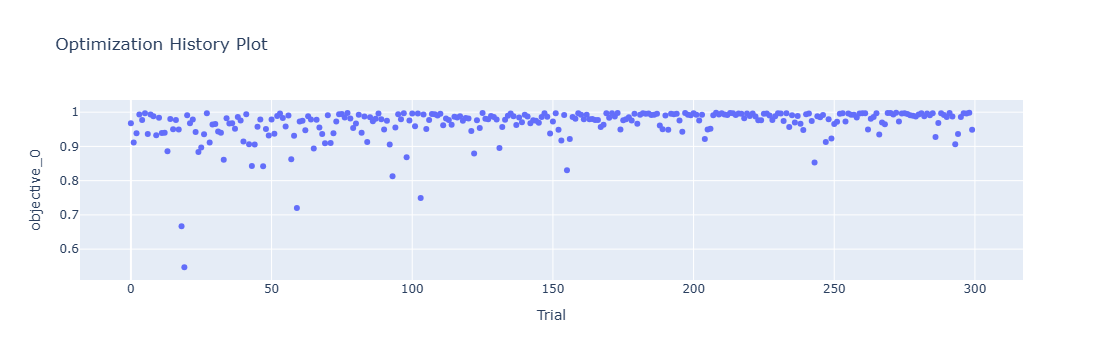

In [16]:
optuna.visualization.plot_optimization_history(study,target=lambda t: t.values[0], target_name='objective_0')

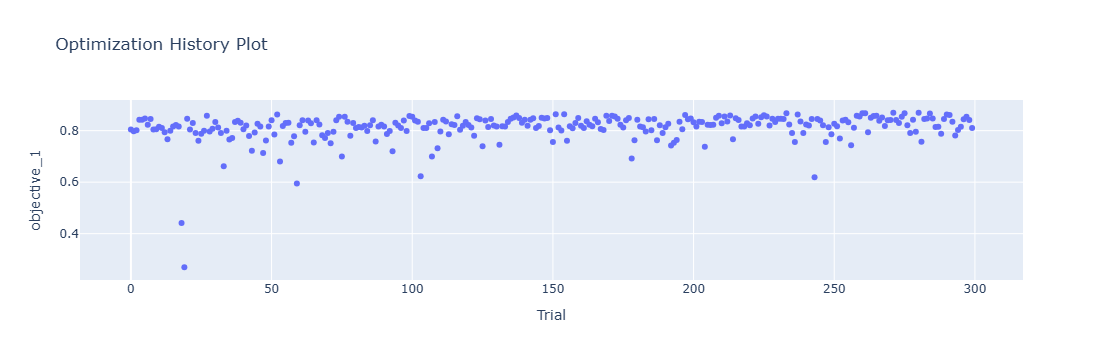

In [17]:
optuna.visualization.plot_optimization_history(study,target=lambda t: t.values[1], target_name='objective_1')

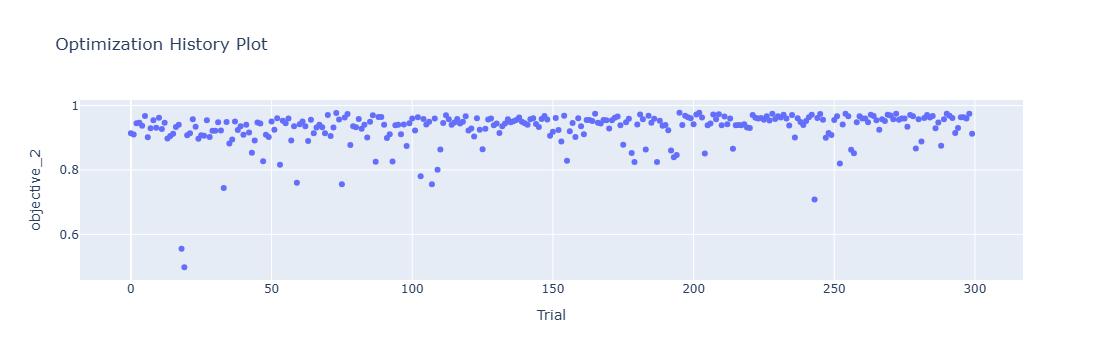

In [18]:
optuna.visualization.plot_optimization_history(study,target=lambda t: t.values[2], target_name='objective_2')

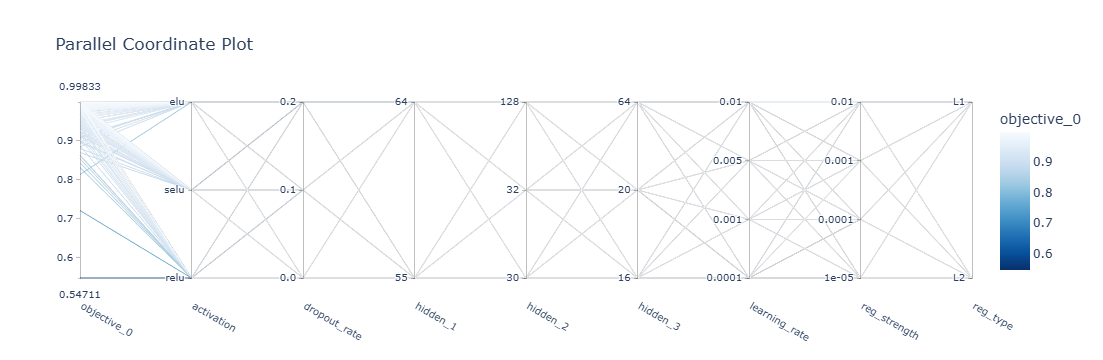

In [19]:
optuna.visualization.plot_parallel_coordinate(study,target=lambda t: t.values[0], target_name='objective_0')

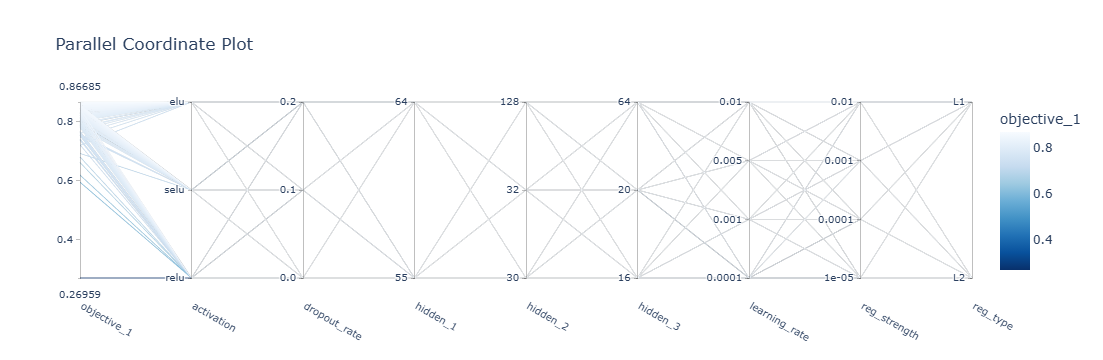

In [20]:
optuna.visualization.plot_parallel_coordinate(study,target=lambda t: t.values[1], target_name='objective_1')

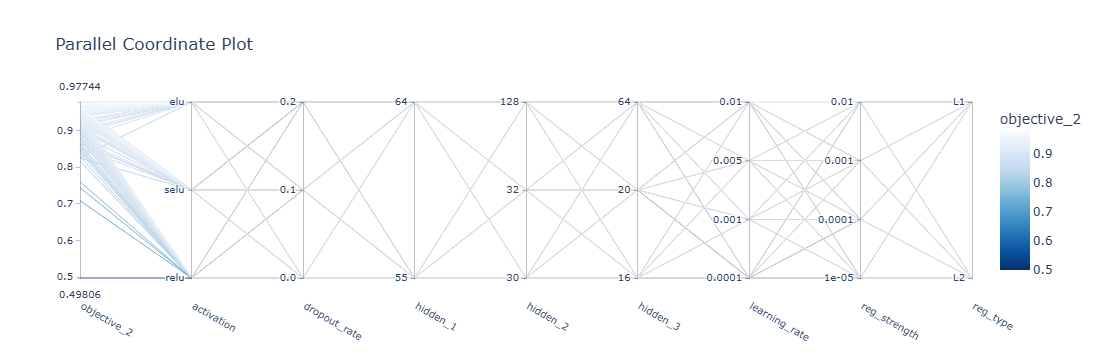

In [21]:
optuna.visualization.plot_parallel_coordinate(study,target=lambda t: t.values[2], target_name='objective_2')

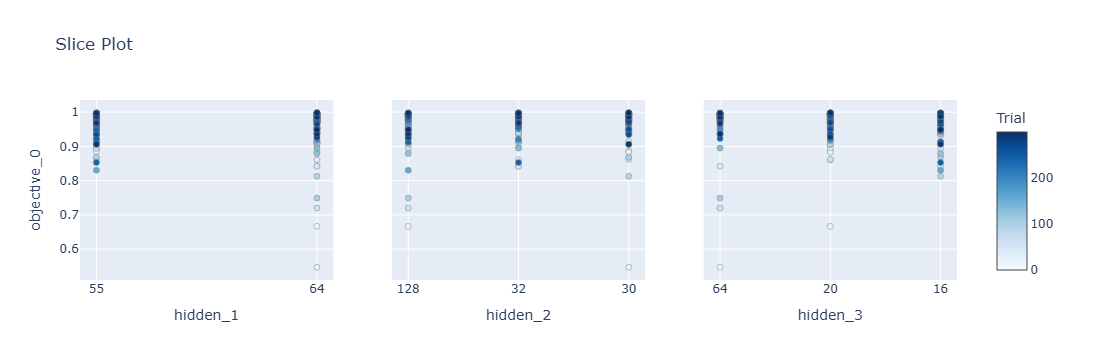

In [22]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[0], target_name='objective_0', params=['hidden_1','hidden_2','hidden_3'])

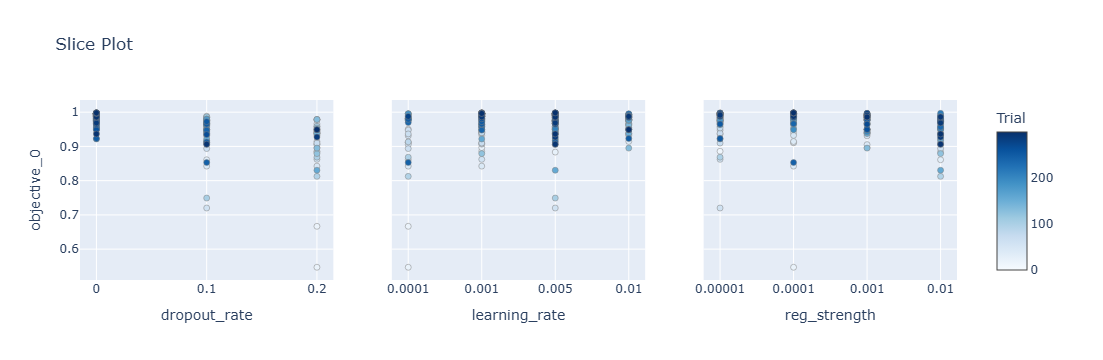

In [23]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[0], target_name='objective_0', params=['dropout_rate','reg_strength','learning_rate'])

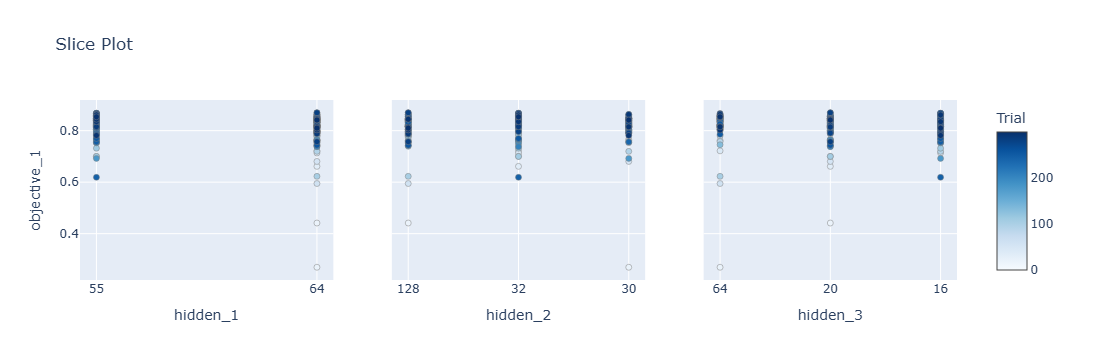

In [24]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[1], target_name='objective_1', params=['hidden_1','hidden_2','hidden_3'])

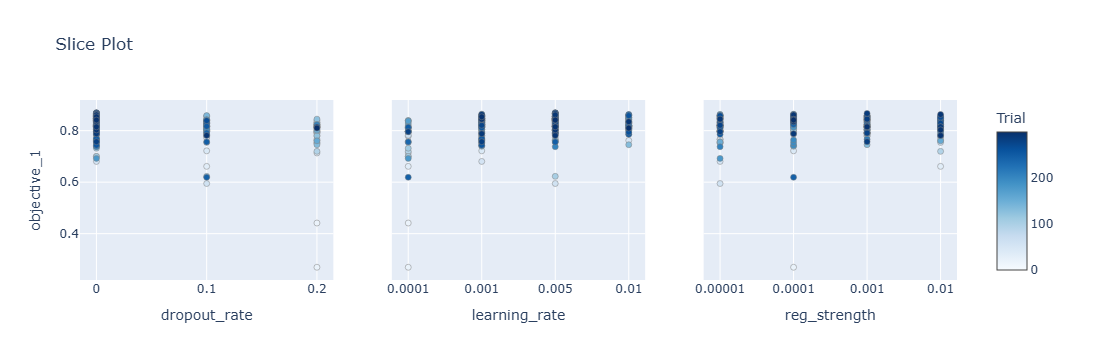

In [25]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[1], target_name='objective_1', params=['dropout_rate','reg_strength','learning_rate'])

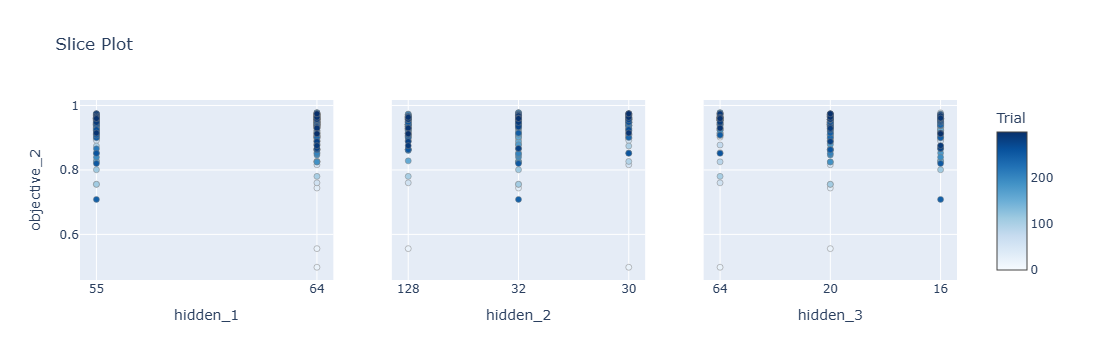

In [26]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[2], target_name='objective_2', params=['hidden_1','hidden_2','hidden_3'])

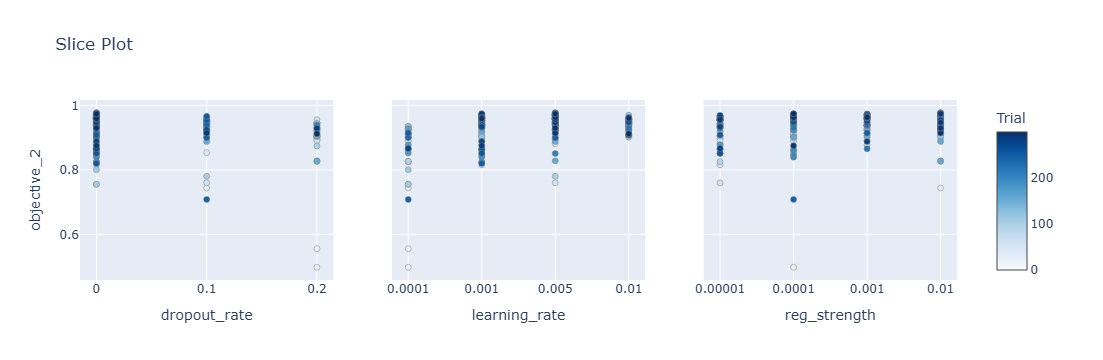

In [27]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[2], target_name='objective_2', params=['dropout_rate','reg_strength','learning_rate'])

3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9966016886316101
Validation set:  0.8634526564061652
Test set:  0.9609762795994274

MAE (eV):

Training set:  0.04339977473513764
Validation set:  0.19742878340591438
Test set:  0.1679560019941032
3/3 [==============================] - 0s 3ms/step


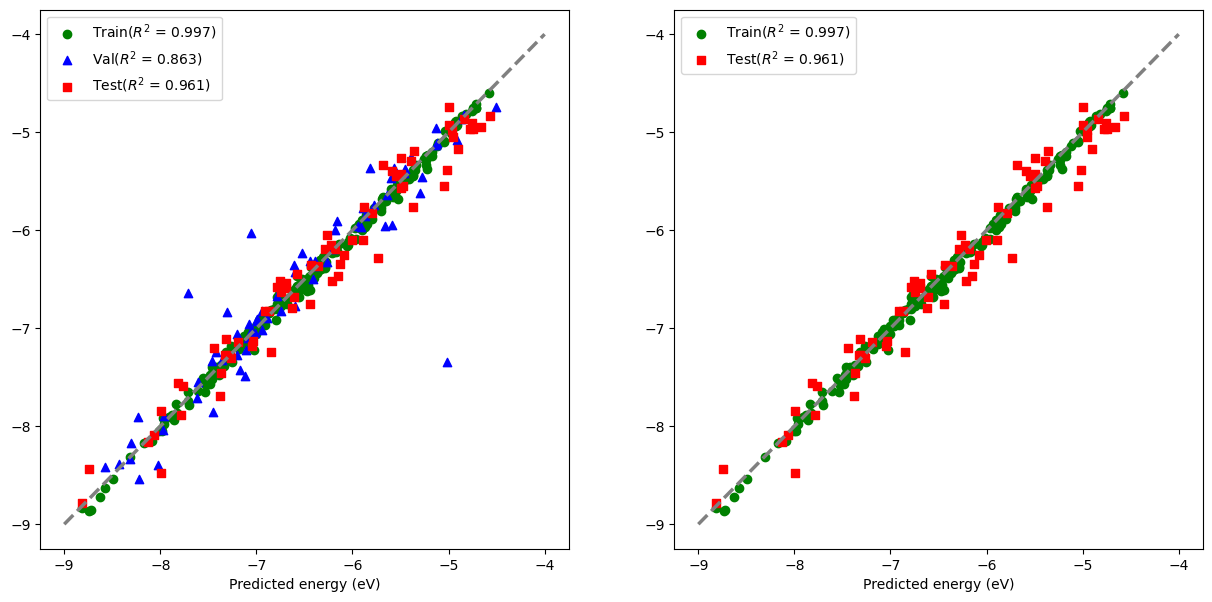

In [63]:
# Trial number: 151

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_151 = tf.keras.Sequential([normalizer])
model_151.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_151.add(layers.Dropout(0.0, seed=SEED))
model_151.add(layers.Dense(30, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_151.add(layers.Dropout(0.0, seed=SEED))
model_151.add(layers.Dense(16, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_151.add(layers.Dropout(0.0, seed=SEED))
model_151.add(layers.Dense(1))

# Compile the model
model_151.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_151 = model_151.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_151 = metrics.r2_score(y_ef_train, model_151.predict(X_ef_train).flatten())
r2_val_151 = metrics.r2_score(y_ef_val, model_151.predict(X_ef_val).flatten())
r2_test_151 = metrics.r2_score(y_ef_test, model_151.predict(X_ef_test).flatten())

mae_train_151 = metrics.mean_absolute_error(y_ef_train, model_151.predict(X_ef_train).flatten())
mae_val_151 = metrics.mean_absolute_error(y_ef_val, model_151.predict(X_ef_val).flatten())
mae_test_151 = metrics.mean_absolute_error(y_ef_test, model_151.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_151)
print('Validation set: ',r2_val_151)
print('Test set: ',r2_test_151)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_151)
print('Validation set: ',mae_val_151)
print('Test set: ',mae_test_151)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_151.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_151:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_151.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_151:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_151.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_151:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_151.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_151:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_151.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_151:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_151_optuna\assets


INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_151_optuna\assets


3/3 [==============================] - 0s 5ms/step


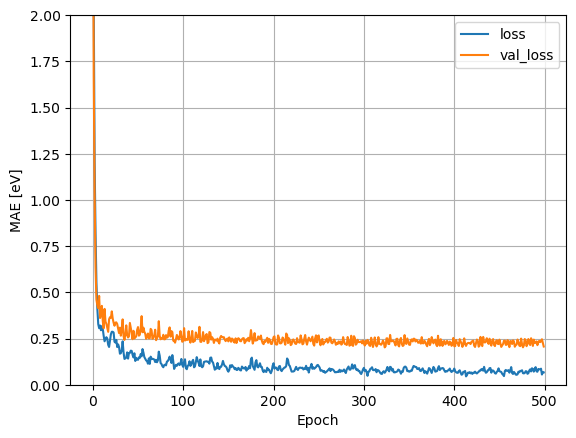

In [64]:
plt.plot(history_151.history['loss'], label='loss')
plt.plot(history_151.history['val_loss'], label='val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

model_151.save(f'Results_Ef/model_151_optuna')

with open(f'Results_Ef/model_151_optuna.pkl', 'wb') as f:
    pickle.dump(history_151.history, f)

y_pred_151_train = model_151.predict(X_ef_train)
y_pred_151_val = model_151.predict(X_ef_val)
y_pred_151_test = model_151.predict(X_ef_test)

pd.DataFrame(y_pred_151_train).to_csv('Results_Ef/y_pred_151_train.csv',index=False)
pd.DataFrame(y_pred_151_val).to_csv('Results_Ef/y_pred_151_val.csv',index=False)
pd.DataFrame(y_pred_151_test).to_csv('Results_Ef/y_pred_151_test.csv',index=False)

3/3 [==============================] - 0s 3ms/step
R2 scores:

Training set:  0.9982743212197365
Validation set:  0.8538079625034324
Test set:  0.966186830926753

MAE (eV):

Training set:  0.03350159524660851
Validation set:  0.20616916039542751
Test set:  0.16122707968198408
3/3 [==============================] - 0s 4ms/step


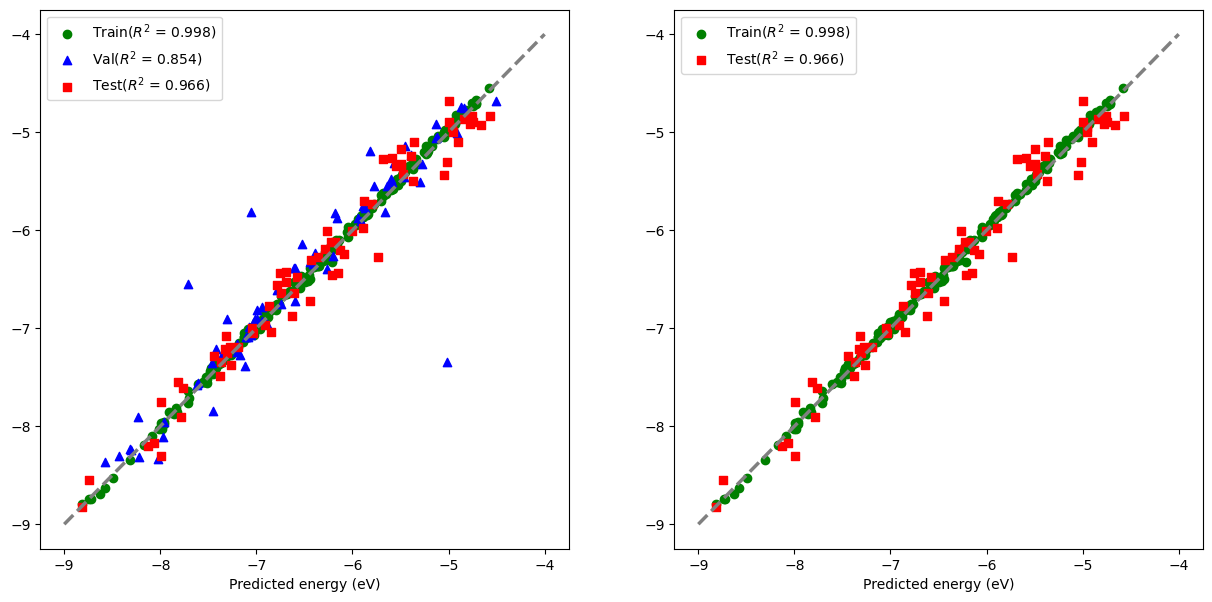

In [33]:
# Trial number: 151 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_151 = tf.keras.Sequential([normalizer])
model_151.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_151.add(layers.Dropout(0.0, seed=SEED))
model_151.add(layers.Dense(30, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_151.add(layers.Dropout(0.0, seed=SEED))
model_151.add(layers.Dense(16, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_151.add(layers.Dropout(0.0, seed=SEED))
model_151.add(layers.Dense(1))

# Compile the model
model_151.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_151 = model_151.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_151 = metrics.r2_score(y_ef_train, model_151.predict(X_ef_train).flatten())
r2_val_151 = metrics.r2_score(y_ef_val, model_151.predict(X_ef_val).flatten())
r2_test_151 = metrics.r2_score(y_ef_test, model_151.predict(X_ef_test).flatten())

mae_train_151 = metrics.mean_absolute_error(y_ef_train, model_151.predict(X_ef_train).flatten())
mae_val_151 = metrics.mean_absolute_error(y_ef_val, model_151.predict(X_ef_val).flatten())
mae_test_151 = metrics.mean_absolute_error(y_ef_test, model_151.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_151)
print('Validation set: ',r2_val_151)
print('Test set: ',r2_test_151)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_151)
print('Validation set: ',mae_val_151)
print('Test set: ',mae_test_151)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_151.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_151:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_151.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_151:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_151.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_151:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_151.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_151:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_151.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_151:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 4ms/step
R2 scores:

Training set:  0.9919643331771753
Validation set:  0.8641188348385787
Test set:  0.9684038740595386

MAE (eV):

Training set:  0.06992185211759662
Validation set:  0.20514411209455835
Test set:  0.15088574445859196
3/3 [==============================] - 0s 6ms/step


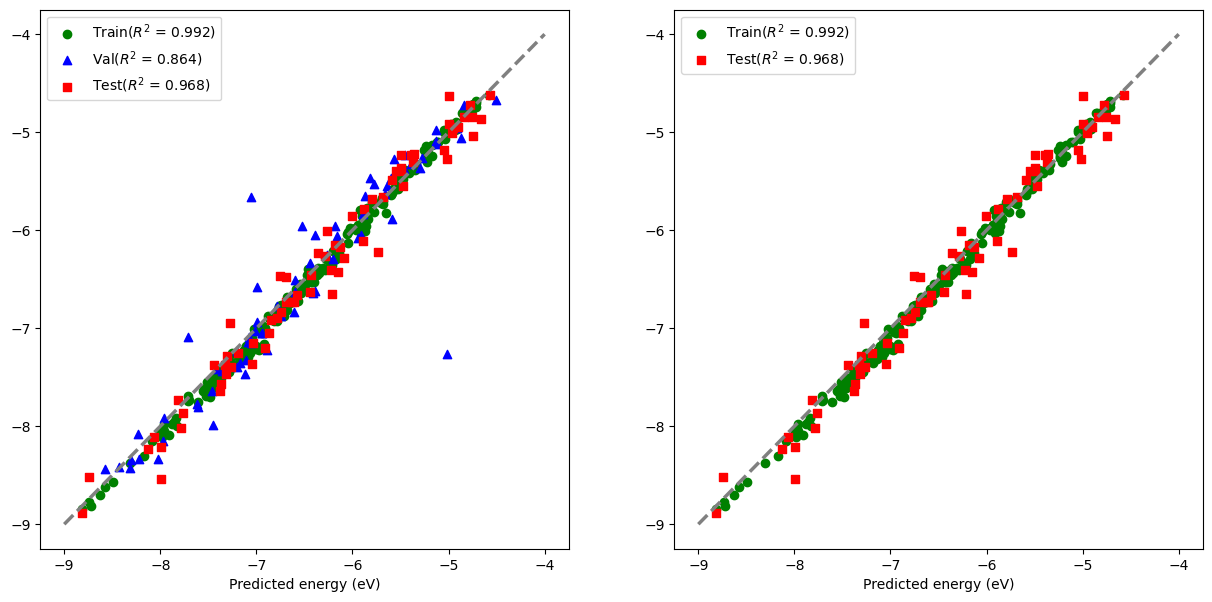

In [61]:
# Trial number: 154

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_154 = tf.keras.Sequential([normalizer])
model_154.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_154.add(layers.Dropout(0.0, seed=SEED))
model_154.add(layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_154.add(layers.Dropout(0.0, seed=SEED))
model_154.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_154.add(layers.Dropout(0.0, seed=SEED))
model_154.add(layers.Dense(1))

# Compile the model
model_154.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_154 = model_154.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_154 = metrics.r2_score(y_ef_train, model_154.predict(X_ef_train).flatten())
r2_val_154 = metrics.r2_score(y_ef_val, model_154.predict(X_ef_val).flatten())
r2_test_154 = metrics.r2_score(y_ef_test, model_154.predict(X_ef_test).flatten())

mae_train_154 = metrics.mean_absolute_error(y_ef_train, model_154.predict(X_ef_train).flatten())
mae_val_154 = metrics.mean_absolute_error(y_ef_val, model_154.predict(X_ef_val).flatten())
mae_test_154 = metrics.mean_absolute_error(y_ef_test, model_154.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_154)
print('Validation set: ',r2_val_154)
print('Test set: ',r2_test_154)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_154)
print('Validation set: ',mae_val_154)
print('Test set: ',mae_test_154)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_154.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_154:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_154.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_154:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_154.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_154:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_154.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_154:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_154.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_154:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_154_optuna\assets


INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_154_optuna\assets


3/3 [==============================] - 0s 0s/step


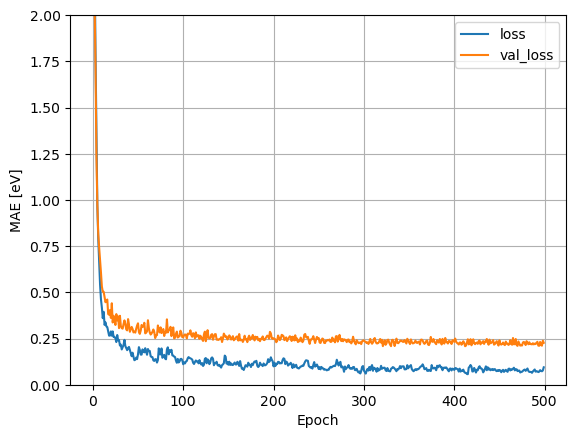

In [62]:
plt.plot(history_154.history['loss'], label='loss')
plt.plot(history_154.history['val_loss'], label='val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

model_154.save(f'Results_Ef/model_154_optuna')

with open(f'Results_Ef/model_154_optuna.pkl', 'wb') as f:
    pickle.dump(history_154.history, f)

y_pred_154_train = model_154.predict(X_ef_train)
y_pred_154_val = model_154.predict(X_ef_val)
y_pred_154_test = model_154.predict(X_ef_test)

pd.DataFrame(y_pred_154_train).to_csv('Results_Ef/y_pred_154_train.csv',index=False)
pd.DataFrame(y_pred_154_val).to_csv('Results_Ef/y_pred_154_val.csv',index=False)
pd.DataFrame(y_pred_154_test).to_csv('Results_Ef/y_pred_154_test.csv',index=False)

3/3 [==============================] - 0s 4ms/step
R2 scores:

Training set:  0.9972092212288778
Validation set:  0.87631629190793
Test set:  0.9689260802002497

MAE (eV):

Training set:  0.0407695897315978
Validation set:  0.18424198314394796
Test set:  0.1393377772165746
3/3 [==============================] - 0s 2ms/step


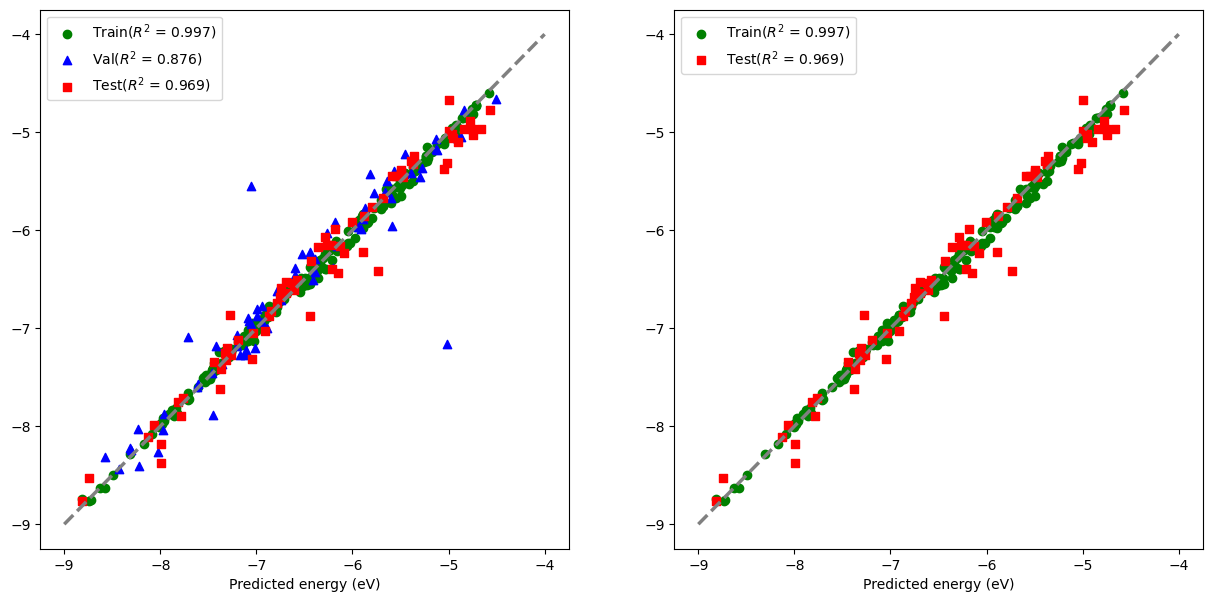

In [35]:
# Trial number: 154 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_154 = tf.keras.Sequential([normalizer])
model_154.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_154.add(layers.Dropout(0.0, seed=SEED))
model_154.add(layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_154.add(layers.Dropout(0.0, seed=SEED))
model_154.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_154.add(layers.Dropout(0.0, seed=SEED))
model_154.add(layers.Dense(1))

# Compile the model
model_154.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_154 = model_154.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_154 = metrics.r2_score(y_ef_train, model_154.predict(X_ef_train).flatten())
r2_val_154 = metrics.r2_score(y_ef_val, model_154.predict(X_ef_val).flatten())
r2_test_154 = metrics.r2_score(y_ef_test, model_154.predict(X_ef_test).flatten())

mae_train_154 = metrics.mean_absolute_error(y_ef_train, model_154.predict(X_ef_train).flatten())
mae_val_154 = metrics.mean_absolute_error(y_ef_val, model_154.predict(X_ef_val).flatten())
mae_test_154 = metrics.mean_absolute_error(y_ef_test, model_154.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_154)
print('Validation set: ',r2_val_154)
print('Test set: ',r2_test_154)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_154)
print('Validation set: ',mae_val_154)
print('Test set: ',mae_test_154)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_154.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_154:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_154.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_154:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_154.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_154:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_154.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_154:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_154.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_154:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9973175407500489
Validation set:  0.8612104445852647
Test set:  0.9677987671681219

MAE (eV):

Training set:  0.03904406530371803
Validation set:  0.20213145785183798
Test set:  0.15790958126936477
3/3 [==============================] - 0s 2ms/step


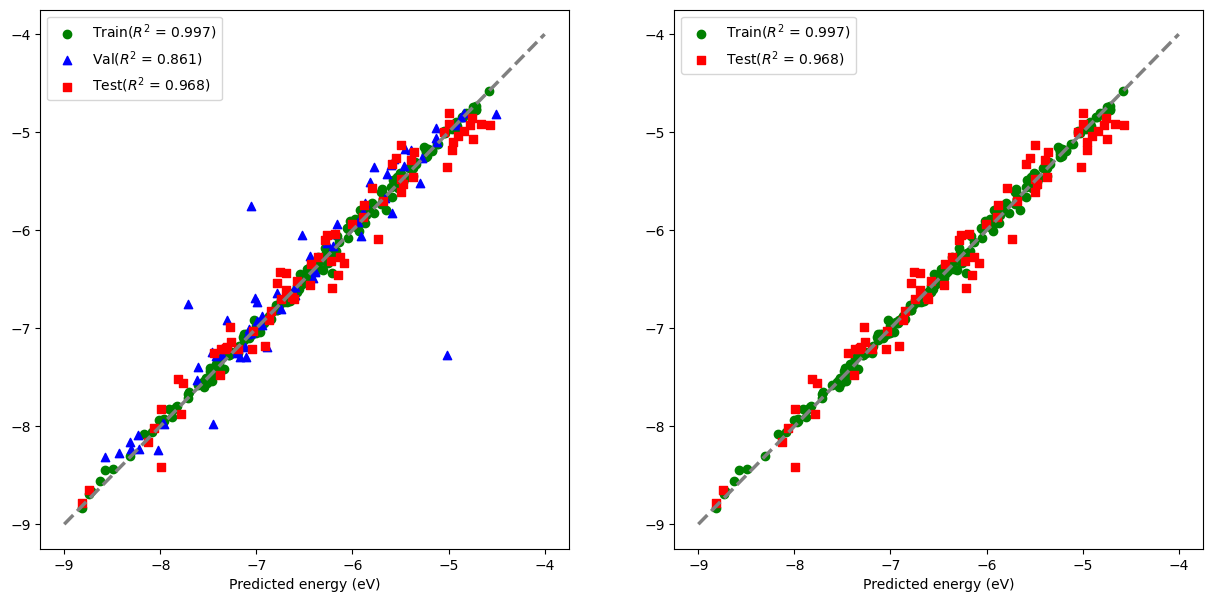

In [59]:
# Trial number: 197

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_197 = tf.keras.Sequential([normalizer])
model_197.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_197.add(layers.Dropout(0.0, seed=SEED))
model_197.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_197.add(layers.Dropout(0.0, seed=SEED))
model_197.add(layers.Dense(16, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_197.add(layers.Dropout(0.0, seed=SEED))
model_197.add(layers.Dense(1))

# Compile the model
model_197.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_197 = model_197.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_197 = metrics.r2_score(y_ef_train, model_197.predict(X_ef_train).flatten())
r2_val_197 = metrics.r2_score(y_ef_val, model_197.predict(X_ef_val).flatten())
r2_test_197 = metrics.r2_score(y_ef_test, model_197.predict(X_ef_test).flatten())

mae_train_197 = metrics.mean_absolute_error(y_ef_train, model_197.predict(X_ef_train).flatten())
mae_val_197 = metrics.mean_absolute_error(y_ef_val, model_197.predict(X_ef_val).flatten())
mae_test_197 = metrics.mean_absolute_error(y_ef_test, model_197.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_197)
print('Validation set: ',r2_val_197)
print('Test set: ',r2_test_197)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_197)
print('Validation set: ',mae_val_197)
print('Test set: ',mae_test_197)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_197.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_197:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_197.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_197:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_197.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_197:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_197.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_197:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_197.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_197:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_197_optuna\assets


INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_197_optuna\assets


3/3 [==============================] - 0s 2ms/step


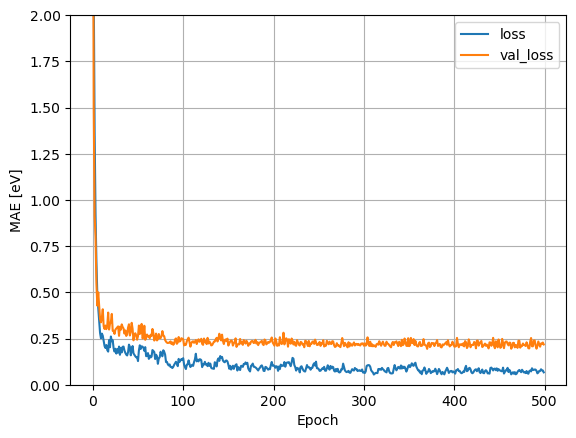

In [60]:
plt.plot(history_197.history['loss'], label='loss')
plt.plot(history_197.history['val_loss'], label='val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

model_197.save(f'Results_Ef/model_197_optuna')

with open(f'Results_Ef/model_197_optuna.pkl', 'wb') as f:
    pickle.dump(history_197.history, f)

y_pred_197_train = model_197.predict(X_ef_train)
y_pred_197_val = model_197.predict(X_ef_val)
y_pred_197_test = model_197.predict(X_ef_test)

pd.DataFrame(y_pred_197_train).to_csv('Results_Ef/y_pred_197_train.csv',index=False)
pd.DataFrame(y_pred_197_val).to_csv('Results_Ef/y_pred_197_val.csv',index=False)
pd.DataFrame(y_pred_197_test).to_csv('Results_Ef/y_pred_197_test.csv',index=False)

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.998536428361238
Validation set:  0.8486986873871557
Test set:  0.9668096587612586

MAE (eV):

Training set:  0.030417774313256377
Validation set:  0.20998002521900874
Test set:  0.15379497480568244
3/3 [==============================] - 0s 2ms/step


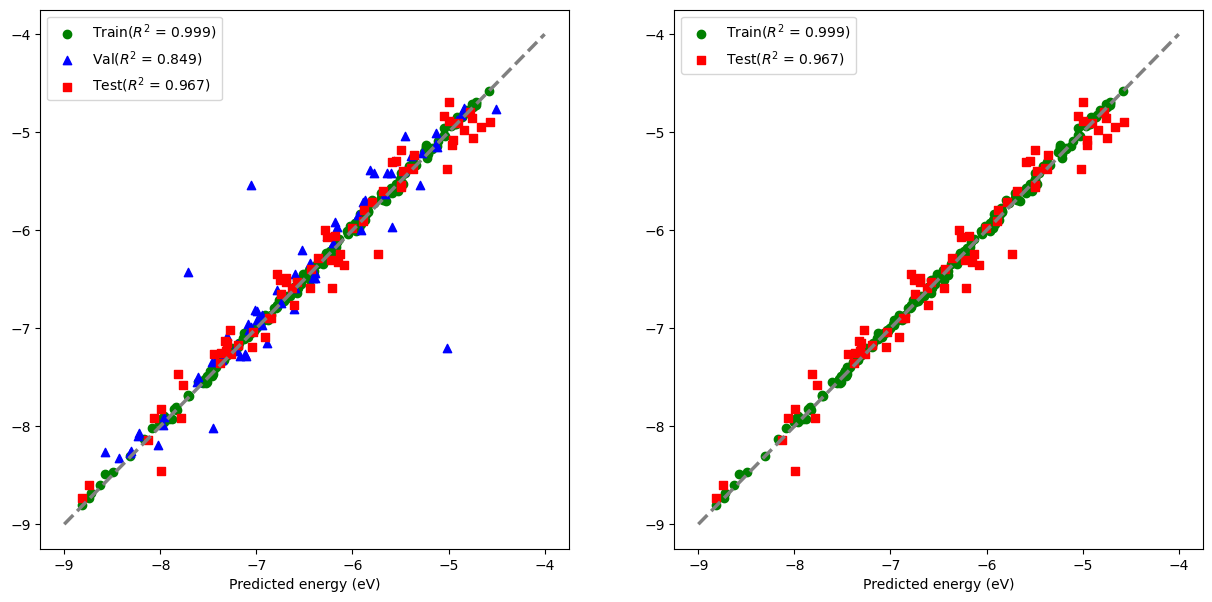

In [37]:
# Trial number: 197 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_197 = tf.keras.Sequential([normalizer])
model_197.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_197.add(layers.Dropout(0.0, seed=SEED))
model_197.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_197.add(layers.Dropout(0.0, seed=SEED))
model_197.add(layers.Dense(16, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_197.add(layers.Dropout(0.0, seed=SEED))
model_197.add(layers.Dense(1))

# Compile the model
model_197.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_197 = model_197.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_197 = metrics.r2_score(y_ef_train, model_197.predict(X_ef_train).flatten())
r2_val_197 = metrics.r2_score(y_ef_val, model_197.predict(X_ef_val).flatten())
r2_test_197 = metrics.r2_score(y_ef_test, model_197.predict(X_ef_test).flatten())

mae_train_197 = metrics.mean_absolute_error(y_ef_train, model_197.predict(X_ef_train).flatten())
mae_val_197 = metrics.mean_absolute_error(y_ef_val, model_197.predict(X_ef_val).flatten())
mae_test_197 = metrics.mean_absolute_error(y_ef_test, model_197.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_197)
print('Validation set: ',r2_val_197)
print('Test set: ',r2_test_197)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_197)
print('Validation set: ',mae_val_197)
print('Test set: ',mae_test_197)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_197.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_197:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_197.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_197:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_197.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_197:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_197.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_197:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_197.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_197:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 3ms/step
R2 scores:

Training set:  0.9974714347831701
Validation set:  0.8590747042807443
Test set:  0.9596528310814844

MAE (eV):

Training set:  0.03579032088584385
Validation set:  0.2170122941500126
Test set:  0.17647016533317358
3/3 [==============================] - 0s 3ms/step


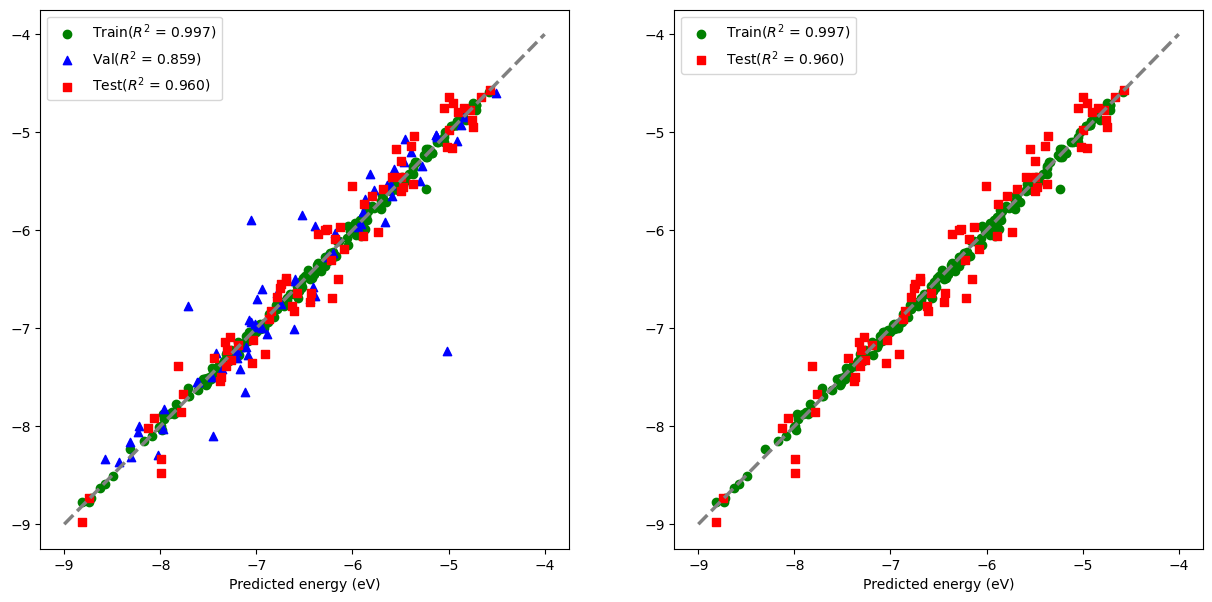

In [57]:
# Trial number: 213

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_213 = tf.keras.Sequential([normalizer])
model_213.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_213.add(layers.Dropout(0.0, seed=SEED))
model_213.add(layers.Dense(30, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_213.add(layers.Dropout(0.0, seed=SEED))
model_213.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_213.add(layers.Dropout(0.0, seed=SEED))
model_213.add(layers.Dense(1))

# Compile the model
model_213.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_213 = model_213.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_213 = metrics.r2_score(y_ef_train, model_213.predict(X_ef_train).flatten())
r2_val_213 = metrics.r2_score(y_ef_val, model_213.predict(X_ef_val).flatten())
r2_test_213 = metrics.r2_score(y_ef_test, model_213.predict(X_ef_test).flatten())

mae_train_213 = metrics.mean_absolute_error(y_ef_train, model_213.predict(X_ef_train).flatten())
mae_val_213 = metrics.mean_absolute_error(y_ef_val, model_213.predict(X_ef_val).flatten())
mae_test_213 = metrics.mean_absolute_error(y_ef_test, model_213.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_213)
print('Validation set: ',r2_val_213)
print('Test set: ',r2_test_213)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_213)
print('Validation set: ',mae_val_213)
print('Test set: ',mae_test_213)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_213.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_213:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_213.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_213:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_213.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_213:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_213.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_213:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_213.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_213:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_213_optuna\assets


INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_213_optuna\assets


3/3 [==============================] - 0s 3ms/step


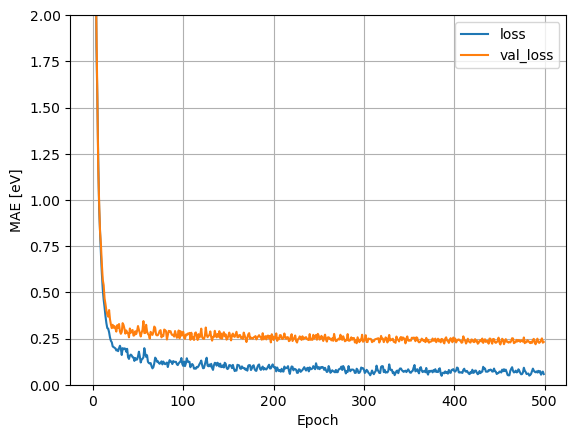

In [58]:
plt.plot(history_213.history['loss'], label='loss')
plt.plot(history_213.history['val_loss'], label='val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

model_213.save(f'Results_Ef/model_213_optuna')

with open(f'Results_Ef/model_213_optuna.pkl', 'wb') as f:
    pickle.dump(history_213.history, f)

y_pred_213_train = model_213.predict(X_ef_train)
y_pred_213_val = model_213.predict(X_ef_val)
y_pred_213_test = model_213.predict(X_ef_test)

pd.DataFrame(y_pred_213_train).to_csv('Results_Ef/y_pred_213_train.csv',index=False)
pd.DataFrame(y_pred_213_val).to_csv('Results_Ef/y_pred_213_val.csv',index=False)
pd.DataFrame(y_pred_213_test).to_csv('Results_Ef/y_pred_213_test.csv',index=False)

3/3 [==============================] - 0s 3ms/step
R2 scores:

Training set:  0.9958086616566868
Validation set:  0.8596871584517988
Test set:  0.9587574787093783

MAE (eV):

Training set:  0.052989029861346876
Validation set:  0.20089145314932202
Test set:  0.175541436494351
3/3 [==============================] - 0s 5ms/step


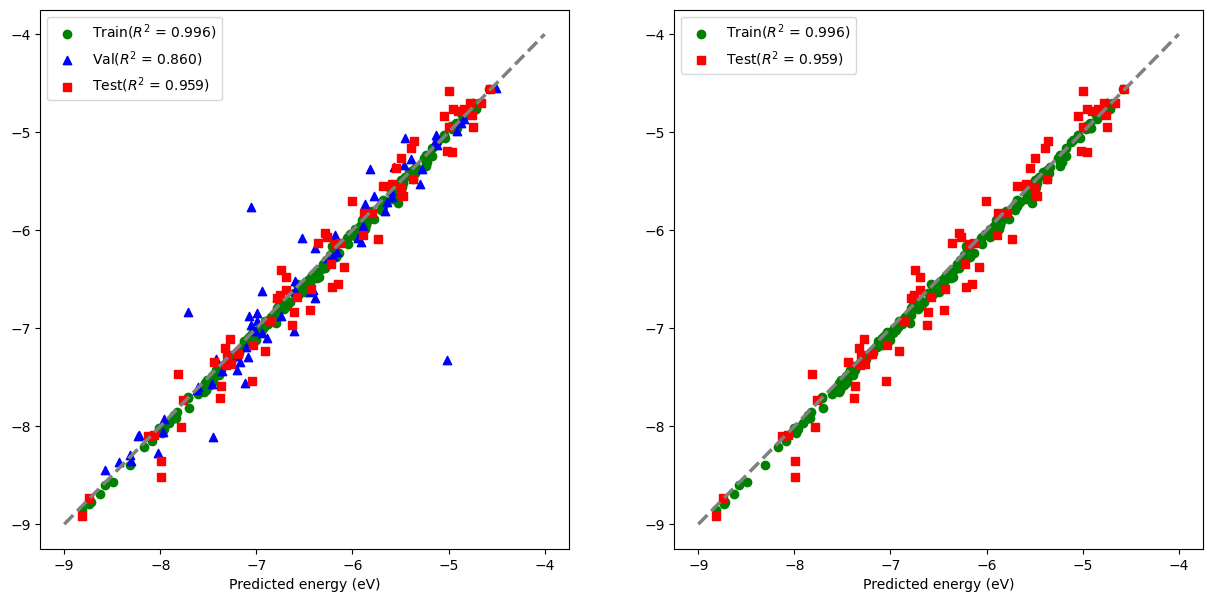

In [39]:
# Trial number: 213 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_213 = tf.keras.Sequential([normalizer])
model_213.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_213.add(layers.Dropout(0.0, seed=SEED))
model_213.add(layers.Dense(30, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_213.add(layers.Dropout(0.0, seed=SEED))
model_213.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.0001)))
model_213.add(layers.Dropout(0.0, seed=SEED))
model_213.add(layers.Dense(1))

# Compile the model
model_213.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_213 = model_213.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_213 = metrics.r2_score(y_ef_train, model_213.predict(X_ef_train).flatten())
r2_val_213 = metrics.r2_score(y_ef_val, model_213.predict(X_ef_val).flatten())
r2_test_213 = metrics.r2_score(y_ef_test, model_213.predict(X_ef_test).flatten())

mae_train_213 = metrics.mean_absolute_error(y_ef_train, model_213.predict(X_ef_train).flatten())
mae_val_213 = metrics.mean_absolute_error(y_ef_val, model_213.predict(X_ef_val).flatten())
mae_test_213 = metrics.mean_absolute_error(y_ef_test, model_213.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_213)
print('Validation set: ',r2_val_213)
print('Test set: ',r2_test_213)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_213)
print('Validation set: ',mae_val_213)
print('Test set: ',mae_test_213)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_213.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_213:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_213.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_213:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_213.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_213:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_213.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_213:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_213.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_213:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9968055134478595
Validation set:  0.8671818527411159
Test set:  0.9595091961214866

MAE (eV):

Training set:  0.04479815789809179
Validation set:  0.19643943796244406
Test set:  0.16788321480752041
3/3 [==============================] - 0s 4ms/step


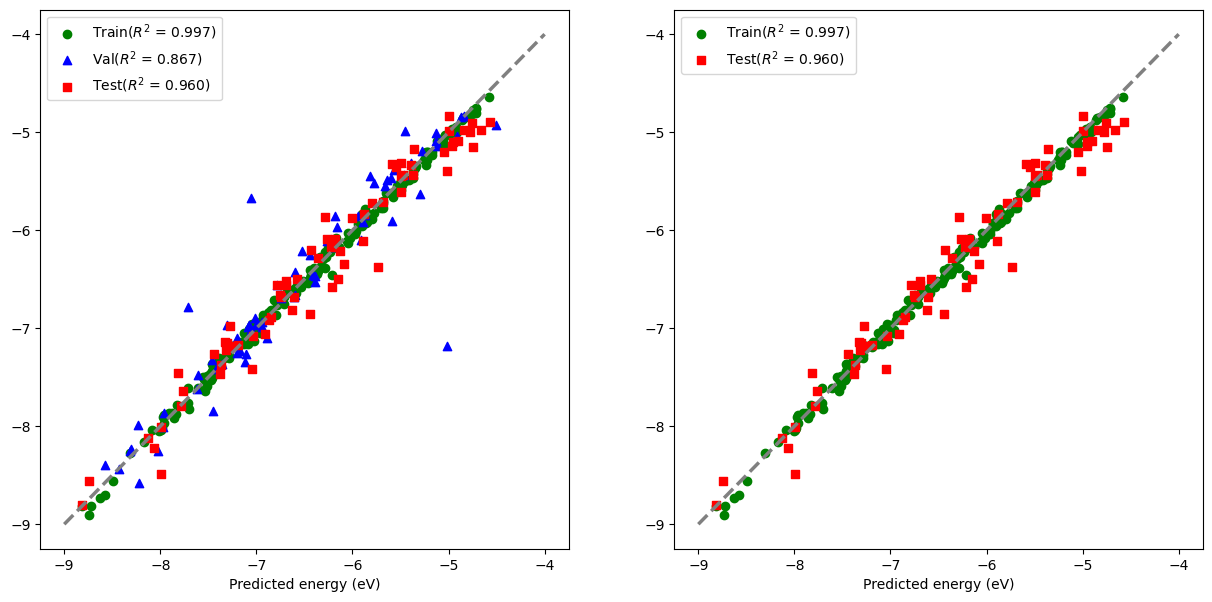

In [55]:
# Trial number: 233

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_233 = tf.keras.Sequential([normalizer])
model_233.add(layers.Dense(55, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_233.add(layers.Dropout(0.0, seed=SEED))
model_233.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_233.add(layers.Dropout(0.0, seed=SEED))
model_233.add(layers.Dense(16, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_233.add(layers.Dropout(0.0, seed=SEED))
model_233.add(layers.Dense(1))

# Compile the model
model_233.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_233 = model_233.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_233 = metrics.r2_score(y_ef_train, model_233.predict(X_ef_train).flatten())
r2_val_233 = metrics.r2_score(y_ef_val, model_233.predict(X_ef_val).flatten())
r2_test_233 = metrics.r2_score(y_ef_test, model_233.predict(X_ef_test).flatten())

mae_train_233 = metrics.mean_absolute_error(y_ef_train, model_233.predict(X_ef_train).flatten())
mae_val_233 = metrics.mean_absolute_error(y_ef_val, model_233.predict(X_ef_val).flatten())
mae_test_233 = metrics.mean_absolute_error(y_ef_test, model_233.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_233)
print('Validation set: ',r2_val_233)
print('Test set: ',r2_test_233)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_233)
print('Validation set: ',mae_val_233)
print('Test set: ',mae_test_233)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_233.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_233:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_233.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_233:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_233.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_233:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_233.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_233:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_233.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_233:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_233_optuna\assets


INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_233_optuna\assets


3/3 [==============================] - 0s 2ms/step


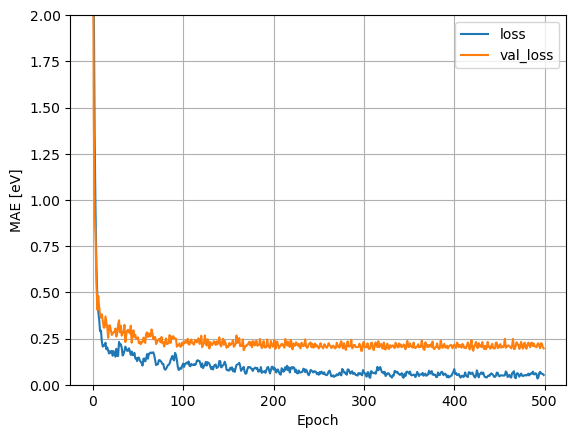

In [56]:
plt.plot(history_233.history['loss'], label='loss')
plt.plot(history_233.history['val_loss'], label='val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

model_233.save(f'Results_Ef/model_233_optuna')

with open(f'Results_Ef/model_233_optuna.pkl', 'wb') as f:
    pickle.dump(history_233.history, f)

y_pred_233_train = model_233.predict(X_ef_train)
y_pred_233_val = model_233.predict(X_ef_val)
y_pred_233_test = model_233.predict(X_ef_test)

pd.DataFrame(y_pred_233_train).to_csv('Results_Ef/y_pred_233_train.csv',index=False)
pd.DataFrame(y_pred_233_val).to_csv('Results_Ef/y_pred_233_val.csv',index=False)
pd.DataFrame(y_pred_233_test).to_csv('Results_Ef/y_pred_233_test.csv',index=False)

3/3 [==============================] - 0s 5ms/step
R2 scores:

Training set:  0.9977520460116944
Validation set:  0.8169425710930882
Test set:  0.9521989801964892

MAE (eV):

Training set:  0.032667802944247655
Validation set:  0.22957844067222452
Test set:  0.17847391949340285
3/3 [==============================] - 0s 2ms/step


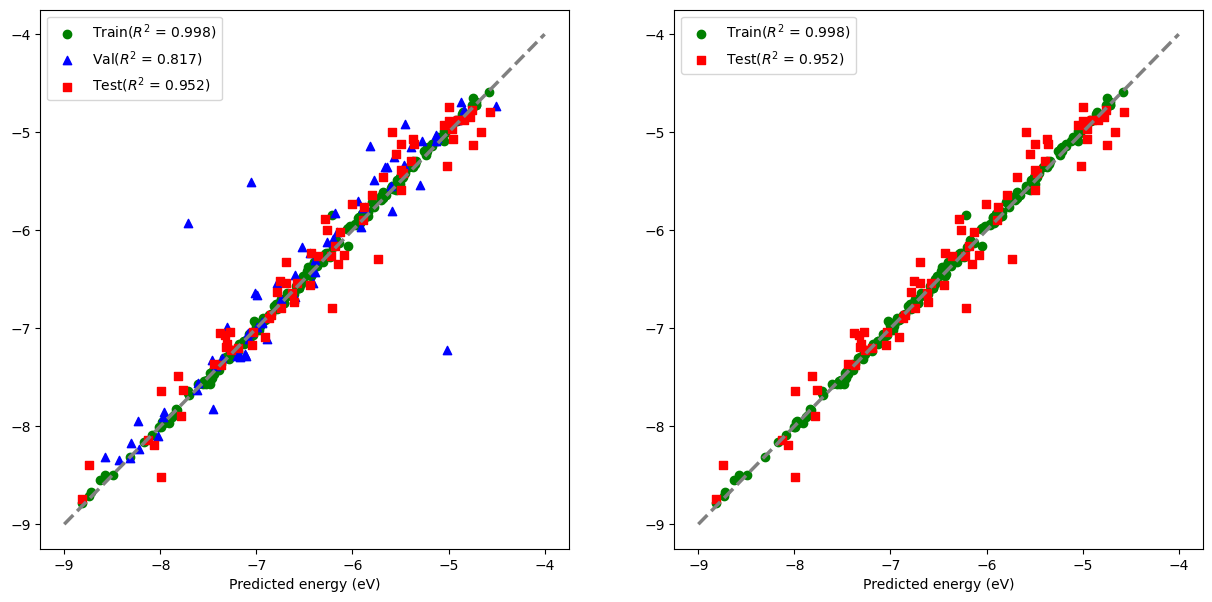

In [41]:
# Trial number: 233 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_233 = tf.keras.Sequential([normalizer])
model_233.add(layers.Dense(55, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_233.add(layers.Dropout(0.0, seed=SEED))
model_233.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_233.add(layers.Dropout(0.0, seed=SEED))
model_233.add(layers.Dense(16, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_233.add(layers.Dropout(0.0, seed=SEED))
model_233.add(layers.Dense(1))

# Compile the model
model_233.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_233 = model_233.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_233 = metrics.r2_score(y_ef_train, model_233.predict(X_ef_train).flatten())
r2_val_233 = metrics.r2_score(y_ef_val, model_233.predict(X_ef_val).flatten())
r2_test_233 = metrics.r2_score(y_ef_test, model_233.predict(X_ef_test).flatten())

mae_train_233 = metrics.mean_absolute_error(y_ef_train, model_233.predict(X_ef_train).flatten())
mae_val_233 = metrics.mean_absolute_error(y_ef_val, model_233.predict(X_ef_val).flatten())
mae_test_233 = metrics.mean_absolute_error(y_ef_test, model_233.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_233)
print('Validation set: ',r2_val_233)
print('Test set: ',r2_test_233)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_233)
print('Validation set: ',mae_val_233)
print('Test set: ',mae_test_233)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_233.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_233:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_233.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_233:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_233.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_233:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_233.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_233:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_233.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_233:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 6ms/step
R2 scores:

Training set:  0.9934134262284141
Validation set:  0.8695833919462435
Test set:  0.9569200188062689

MAE (eV):

Training set:  0.06456510518779796
Validation set:  0.2070589939579519
Test set:  0.18311180816069078
3/3 [==============================] - 0s 2ms/step


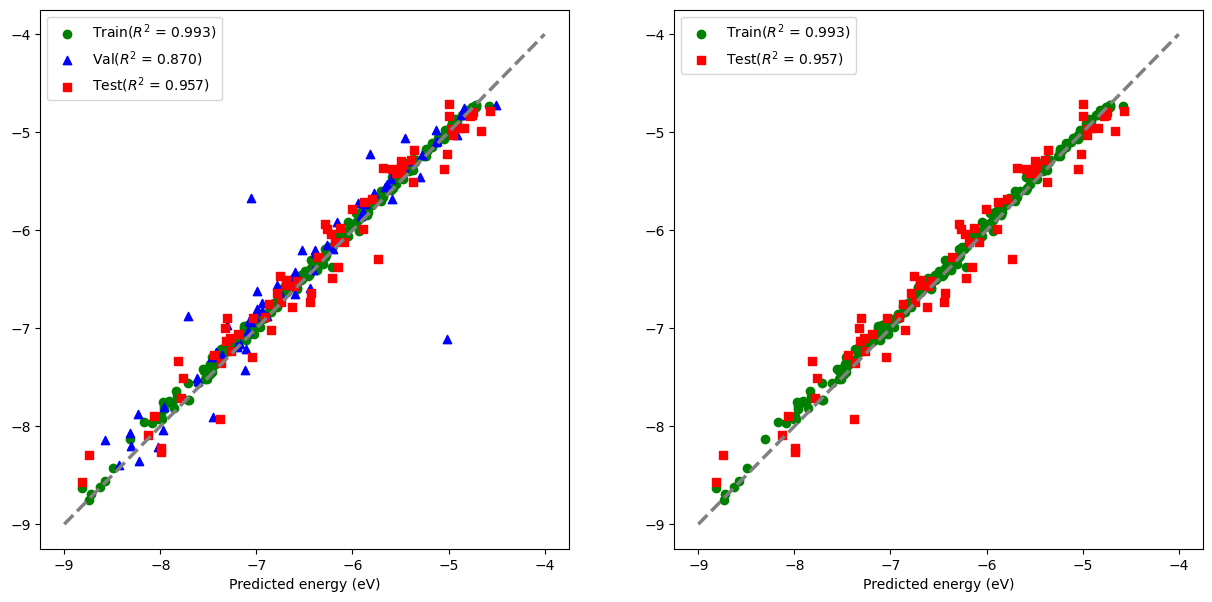

In [53]:
# Trial number: 271

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_271 = tf.keras.Sequential([normalizer])
model_271.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_271.add(layers.Dropout(0.0, seed=SEED))
model_271.add(layers.Dense(128, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_271.add(layers.Dropout(0.0, seed=SEED))
model_271.add(layers.Dense(20, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_271.add(layers.Dropout(0.0, seed=SEED))
model_271.add(layers.Dense(1))

# Compile the model
model_271.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_271 = model_271.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_271 = metrics.r2_score(y_ef_train, model_271.predict(X_ef_train).flatten())
r2_val_271 = metrics.r2_score(y_ef_val, model_271.predict(X_ef_val).flatten())
r2_test_271 = metrics.r2_score(y_ef_test, model_271.predict(X_ef_test).flatten())

mae_train_271 = metrics.mean_absolute_error(y_ef_train, model_271.predict(X_ef_train).flatten())
mae_val_271 = metrics.mean_absolute_error(y_ef_val, model_271.predict(X_ef_val).flatten())
mae_test_271 = metrics.mean_absolute_error(y_ef_test, model_271.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_271)
print('Validation set: ',r2_val_271)
print('Test set: ',r2_test_271)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_271)
print('Validation set: ',mae_val_271)
print('Test set: ',mae_test_271)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_271.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_271:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_271.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_271:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_271.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_271:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_271.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_271:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_271.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_271:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_271_optuna\assets


INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_271_optuna\assets


3/3 [==============================] - 0s 2ms/step


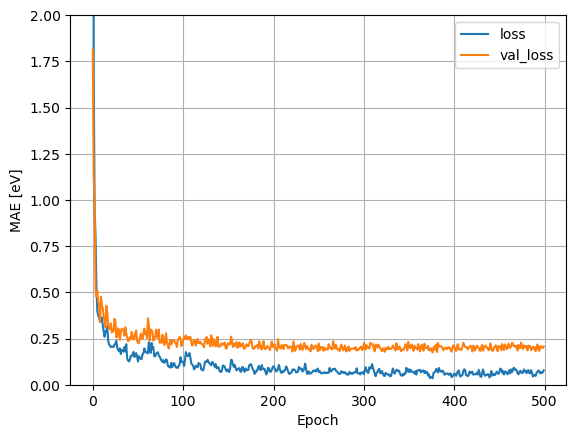

In [54]:
plt.plot(history_271.history['loss'], label='loss')
plt.plot(history_271.history['val_loss'], label='val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

model_271.save(f'Results_Ef/model_271_optuna')

with open(f'Results_Ef/model_271_optuna.pkl', 'wb') as f:
    pickle.dump(history_271.history, f)

y_pred_271_train = model_271.predict(X_ef_train)
y_pred_271_val = model_271.predict(X_ef_val)
y_pred_271_test = model_271.predict(X_ef_test)

pd.DataFrame(y_pred_271_train).to_csv('Results_Ef/y_pred_271_train.csv',index=False)
pd.DataFrame(y_pred_271_val).to_csv('Results_Ef/y_pred_271_val.csv',index=False)
pd.DataFrame(y_pred_271_test).to_csv('Results_Ef/y_pred_271_test.csv',index=False)

3/3 [==============================] - 0s 3ms/step
R2 scores:

Training set:  0.9971674157625605
Validation set:  0.8452931096625057
Test set:  0.9651327929498866

MAE (eV):

Training set:  0.04189372861055793
Validation set:  0.20245481228425913
Test set:  0.15556436270564478
3/3 [==============================] - 0s 3ms/step


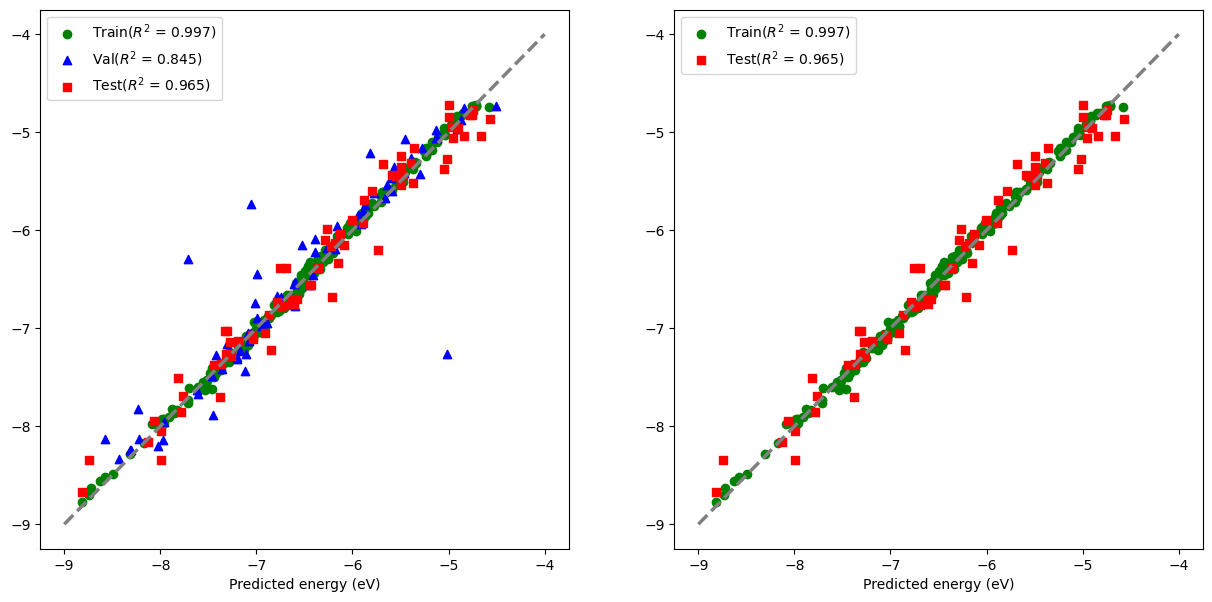

In [43]:
# Trial number: 271 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_271 = tf.keras.Sequential([normalizer])
model_271.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_271.add(layers.Dropout(0.0, seed=SEED))
model_271.add(layers.Dense(128, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_271.add(layers.Dropout(0.0, seed=SEED))
model_271.add(layers.Dense(20, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_271.add(layers.Dropout(0.0, seed=SEED))
model_271.add(layers.Dense(1))

# Compile the model
model_271.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_271 = model_271.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_271 = metrics.r2_score(y_ef_train, model_271.predict(X_ef_train).flatten())
r2_val_271 = metrics.r2_score(y_ef_val, model_271.predict(X_ef_val).flatten())
r2_test_271 = metrics.r2_score(y_ef_test, model_271.predict(X_ef_test).flatten())

mae_train_271 = metrics.mean_absolute_error(y_ef_train, model_271.predict(X_ef_train).flatten())
mae_val_271 = metrics.mean_absolute_error(y_ef_val, model_271.predict(X_ef_val).flatten())
mae_test_271 = metrics.mean_absolute_error(y_ef_test, model_271.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_271)
print('Validation set: ',r2_val_271)
print('Test set: ',r2_test_271)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_271)
print('Validation set: ',mae_val_271)
print('Test set: ',mae_test_271)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_271.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_271:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_271.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_271:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_271.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_271:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_271.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_271:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_271.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_271:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

## BEST MODEL TO USE 284

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9910392522432523
Validation set:  0.8668462857170972
Test set:  0.9623247242557454

MAE (eV):

Training set:  0.06904213451543711
Validation set:  0.1987932728999929
Test set:  0.16137320412937176
3/3 [==============================] - 0s 1ms/step


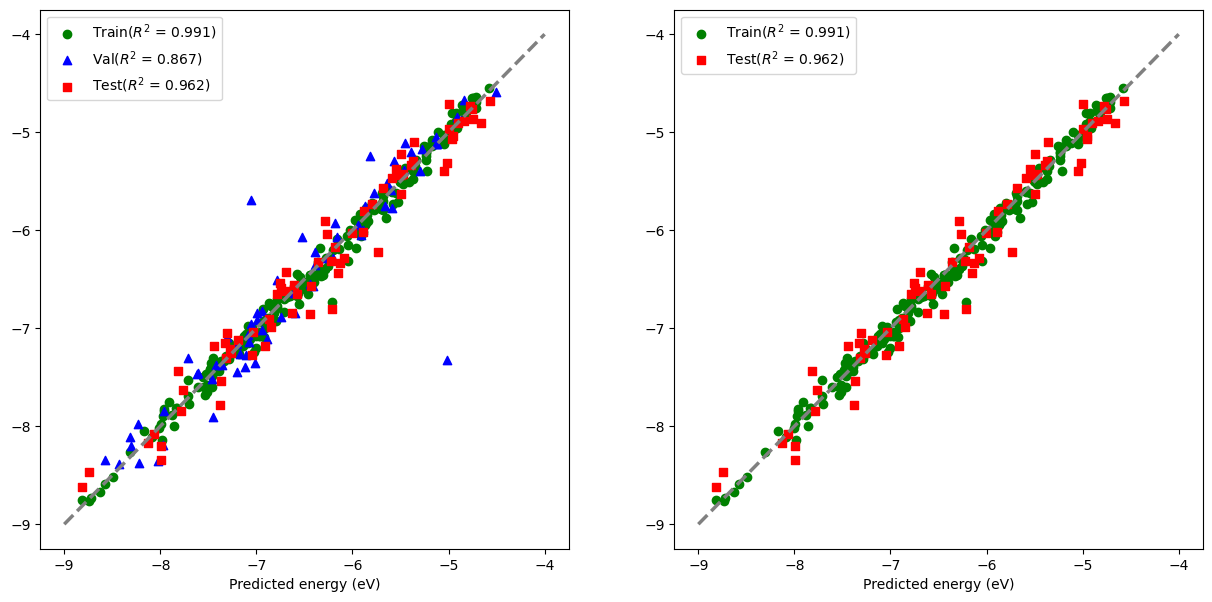

In [51]:
# Trial number: 284

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_284 = tf.keras.Sequential([normalizer])
model_284.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_284.add(layers.Dropout(0.0, seed=SEED))
model_284.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_284.add(layers.Dropout(0.0, seed=SEED))
model_284.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_284.add(layers.Dropout(0.0, seed=SEED))
model_284.add(layers.Dense(1))

# Compile the model
model_284.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_284 = model_284.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_284 = metrics.r2_score(y_ef_train, model_284.predict(X_ef_train).flatten())
r2_val_284 = metrics.r2_score(y_ef_val, model_284.predict(X_ef_val).flatten())
r2_test_284 = metrics.r2_score(y_ef_test, model_284.predict(X_ef_test).flatten())

mae_train_284 = metrics.mean_absolute_error(y_ef_train, model_284.predict(X_ef_train).flatten())
mae_val_284 = metrics.mean_absolute_error(y_ef_val, model_284.predict(X_ef_val).flatten())
mae_test_284 = metrics.mean_absolute_error(y_ef_test, model_284.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_284)
print('Validation set: ',r2_val_284)
print('Test set: ',r2_test_284)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_284)
print('Validation set: ',mae_val_284)
print('Test set: ',mae_test_284)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_284.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_284:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_284.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_284:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_284.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_284:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_284.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_284:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_284.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_284:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_284_optuna\assets


INFO:tensorflow:Assets written to: Results_Ef/Optuna/model_284_optuna\assets


3/3 [==============================] - 0s 2ms/step


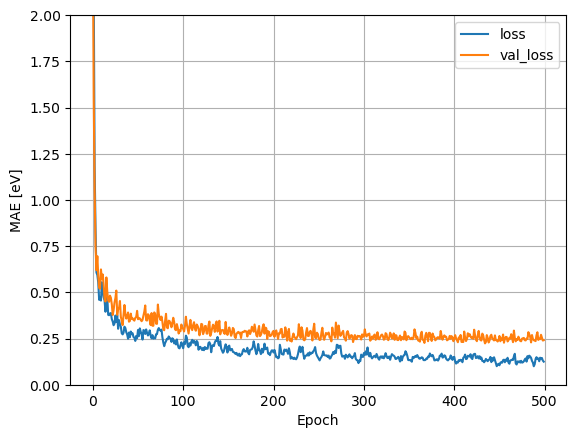

In [52]:
plt.plot(history_284.history['loss'], label='loss')
plt.plot(history_284.history['val_loss'], label='val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

model_284.save(f'Results_Ef/model_284_optuna')

with open(f'Results_Ef/model_284_optuna.pkl', 'wb') as f:
    pickle.dump(history_284.history, f)

y_pred_284_train = model_284.predict(X_ef_train)
y_pred_284_val = model_284.predict(X_ef_val)
y_pred_284_test = model_284.predict(X_ef_test)

pd.DataFrame(y_pred_284_train).to_csv('Results_Ef/y_pred_284_train.csv',index=False)
pd.DataFrame(y_pred_284_val).to_csv('Results_Ef/y_pred_284_val.csv',index=False)
pd.DataFrame(y_pred_284_test).to_csv('Results_Ef/y_pred_284_test.csv',index=False)

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.994141675889134
Validation set:  0.8197098659660585
Test set:  0.972264459298445

MAE (eV):

Training set:  0.05645088295389837
Validation set:  0.22906973570012476
Test set:  0.14385005259357567
3/3 [==============================] - 0s 3ms/step


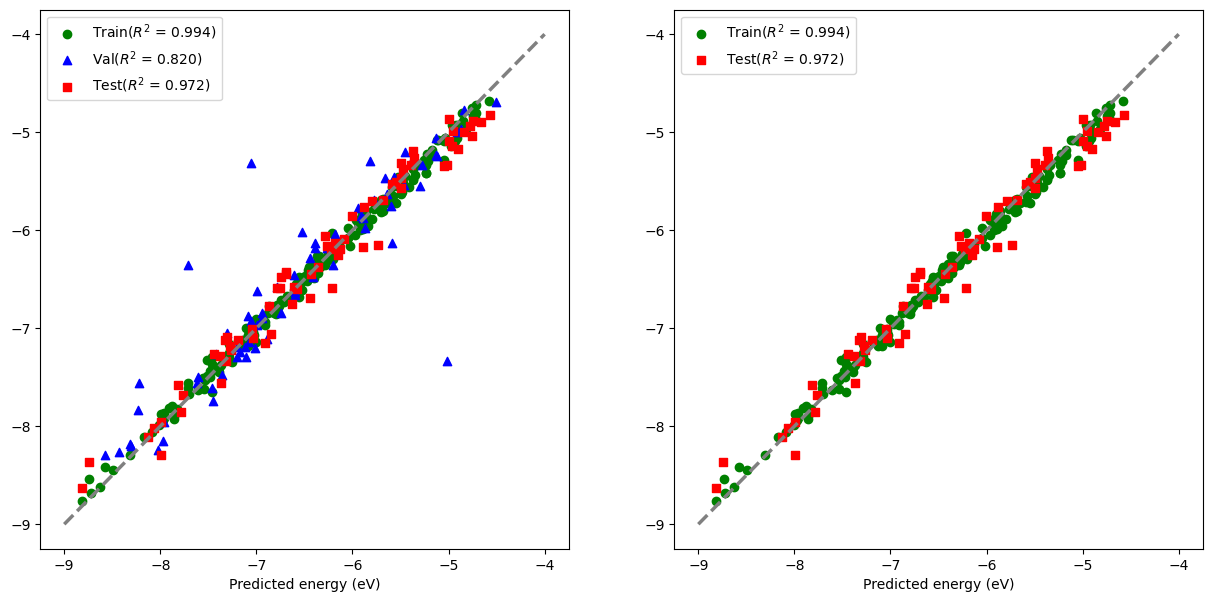

In [45]:
# Trial number: 284 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_284 = tf.keras.Sequential([normalizer])
model_284.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_284.add(layers.Dropout(0.0, seed=SEED))
model_284.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_284.add(layers.Dropout(0.0, seed=SEED))
model_284.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_284.add(layers.Dropout(0.0, seed=SEED))
model_284.add(layers.Dense(1))

# Compile the model
model_284.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_284 = model_284.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_284 = metrics.r2_score(y_ef_train, model_284.predict(X_ef_train).flatten())
r2_val_284 = metrics.r2_score(y_ef_val, model_284.predict(X_ef_val).flatten())
r2_test_284 = metrics.r2_score(y_ef_test, model_284.predict(X_ef_test).flatten())

mae_train_284 = metrics.mean_absolute_error(y_ef_train, model_284.predict(X_ef_train).flatten())
mae_val_284 = metrics.mean_absolute_error(y_ef_val, model_284.predict(X_ef_val).flatten())
mae_test_284 = metrics.mean_absolute_error(y_ef_test, model_284.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_284)
print('Validation set: ',r2_val_284)
print('Test set: ',r2_test_284)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_284)
print('Validation set: ',mae_val_284)
print('Test set: ',mae_test_284)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_284.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_284:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_284.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_284:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_284.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_284:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_284.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_284:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_284.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_284:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 1ms/step
R2 scores:

Training set:  0.986187543262225
Validation set:  0.8629111162351701
Test set:  0.9740365277808848

MAE (eV):

Training set:  0.06309593780010664
Validation set:  0.18448911495927045
Test set:  0.14145367197946193
3/3 [==============================] - 0s 4ms/step


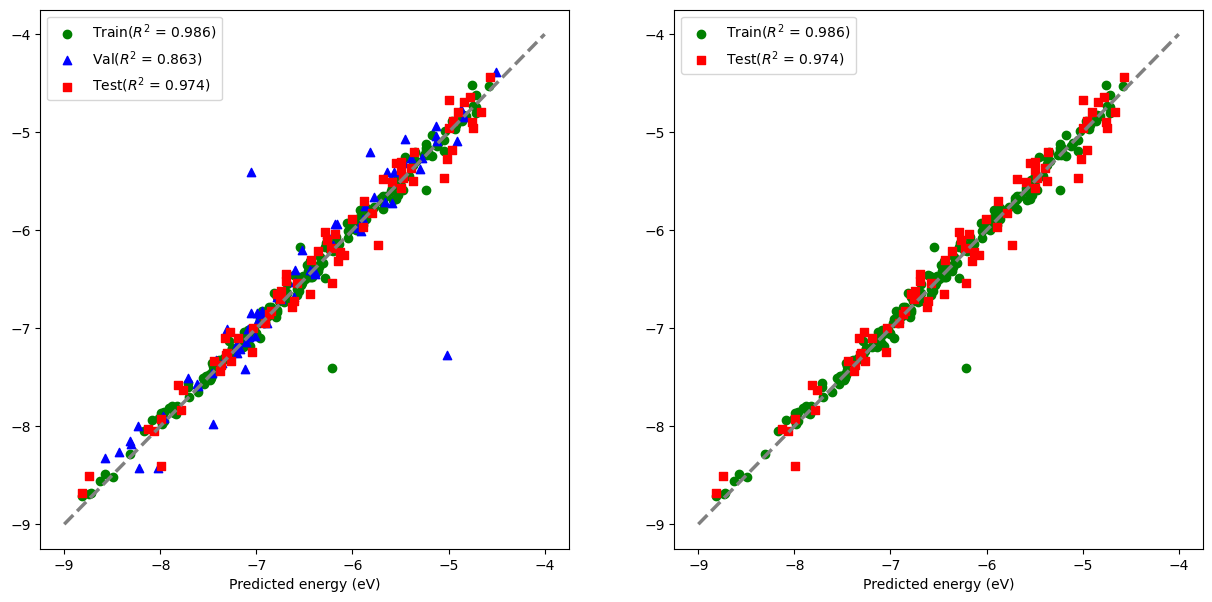

In [48]:
# Trial number: 290

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_290 = tf.keras.Sequential([normalizer])
model_290.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model_290.add(layers.Dropout(0.0, seed=SEED))
model_290.add(layers.Dense(30, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model_290.add(layers.Dropout(0.0, seed=SEED))
model_290.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model_290.add(layers.Dropout(0.0, seed=SEED))
model_290.add(layers.Dense(1))

# Compile the model
model_290.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_290 = model_290.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_290 = metrics.r2_score(y_ef_train, model_290.predict(X_ef_train).flatten())
r2_val_290 = metrics.r2_score(y_ef_val, model_290.predict(X_ef_val).flatten())
r2_test_290 = metrics.r2_score(y_ef_test, model_290.predict(X_ef_test).flatten())

mae_train_290 = metrics.mean_absolute_error(y_ef_train, model_290.predict(X_ef_train).flatten())
mae_val_290 = metrics.mean_absolute_error(y_ef_val, model_290.predict(X_ef_val).flatten())
mae_test_290 = metrics.mean_absolute_error(y_ef_test, model_290.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_290)
print('Validation set: ',r2_val_290)
print('Test set: ',r2_test_290)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_290)
print('Validation set: ',mae_val_290)
print('Test set: ',mae_test_290)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_290.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_290:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_290.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_290:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_290.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_290:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_290.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_290:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_290.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_290:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9838886552014816
Validation set:  0.8499029072153741
Test set:  0.9775630430501934

MAE (eV):

Training set:  0.06456208254377233
Validation set:  0.1964831041328515
Test set:  0.12668405820626857
3/3 [==============================] - 0s 2ms/step


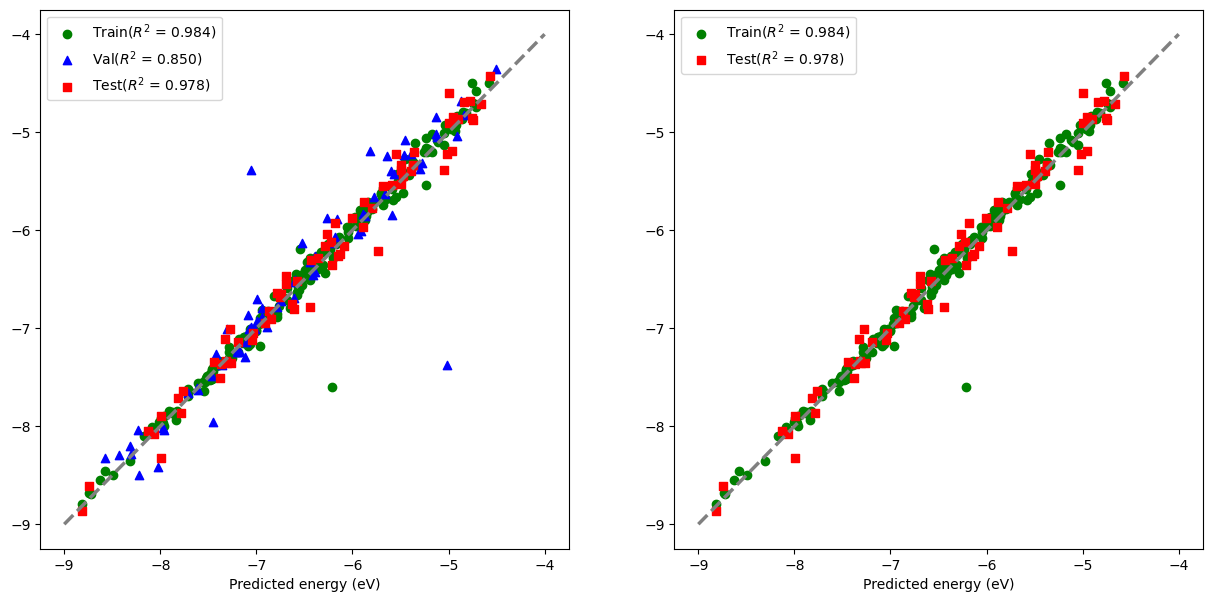

In [47]:
# Trial number: 290 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_ef_train))

# Model definition
model_290 = tf.keras.Sequential([normalizer])
model_290.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model_290.add(layers.Dropout(0.0, seed=SEED))
model_290.add(layers.Dense(30, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model_290.add(layers.Dropout(0.0, seed=SEED))
model_290.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model_290.add(layers.Dropout(0.0, seed=SEED))
model_290.add(layers.Dense(1))

# Compile the model
model_290.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_290 = model_290.fit(X_ef_train, y_ef_train, validation_data=(X_ef_val, y_ef_val), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_290 = metrics.r2_score(y_ef_train, model_290.predict(X_ef_train).flatten())
r2_val_290 = metrics.r2_score(y_ef_val, model_290.predict(X_ef_val).flatten())
r2_test_290 = metrics.r2_score(y_ef_test, model_290.predict(X_ef_test).flatten())

mae_train_290 = metrics.mean_absolute_error(y_ef_train, model_290.predict(X_ef_train).flatten())
mae_val_290 = metrics.mean_absolute_error(y_ef_val, model_290.predict(X_ef_val).flatten())
mae_test_290 = metrics.mean_absolute_error(y_ef_test, model_290.predict(X_ef_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_290)
print('Validation set: ',r2_val_290)
print('Test set: ',r2_test_290)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_290)
print('Validation set: ',mae_val_290)
print('Test set: ',mae_test_290)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_ef_train, model_290.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_290:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, model_290.predict(X_ef_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_290:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, model_290.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_290:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, model_290.predict(X_ef_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_290:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, model_290.predict(X_ef_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_290:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

In [1]:
## predicting Ef for 785 candidates using best model 284

In [8]:
X_ef_train = pd.read_csv('Results_Ef/X_train_FFNN.csv')
X_ef_val = pd.read_csv('Results_Ef/X_val_FFNN.csv')
X_ef_test = pd.read_csv('Results_Ef/X_test_FFNN.csv')

y_train = pd.read_csv('Results_Ef/y_train_FFNN.csv')
y_val = pd.read_csv('Results_Ef/y_val_FFNN.csv')
y_test = pd.read_csv('Results_Ef/y_test_FFNN.csv')

y_ef_train = y_train['55']
y_ef_val = y_val['55']
y_ef_test = y_test['55']

In [9]:
from keras.layers import TFSMLayer

In [12]:
loaded_model_284 = TFSMLayer("Results_Ef/model_284_optuna", call_endpoint='serving_default')  

In [14]:
pred_y_train = np.concatenate([i.numpy().flatten() for i in loaded_model_284(X_ef_train).values()])
pred_y_val = np.concatenate([i.numpy().flatten() for i in loaded_model_284(X_ef_val).values()])
pred_y_test = np.concatenate([i.numpy().flatten() for i in loaded_model_284(X_ef_test).values()])

In [16]:
r2_train_284 = metrics.r2_score(y_ef_train,pd.DataFrame(pred_y_train))
r2_val_284 = metrics.r2_score(y_ef_val,pd.DataFrame(pred_y_val))
r2_test_284 = metrics.r2_score(y_ef_test,pd.DataFrame(pred_y_test))

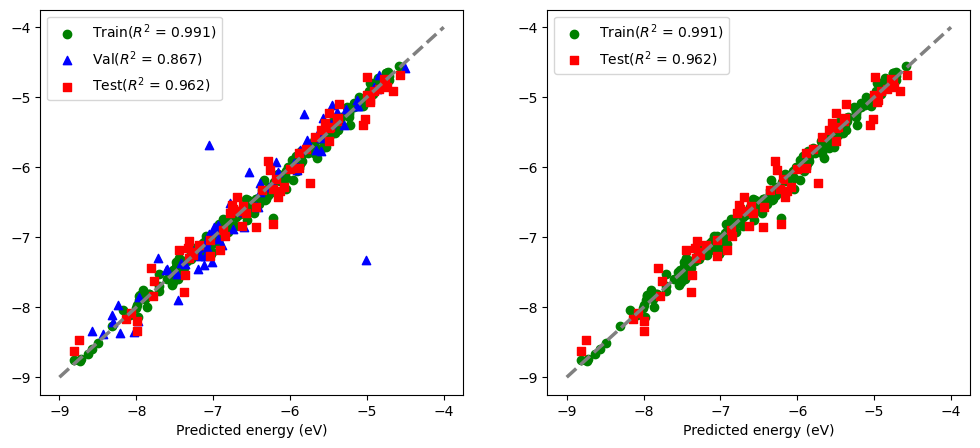

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(y_ef_train, pred_y_train,label='Train($R^2$ = '+str(f'{r2_train_284:.3f}')+')',marker='o',color='green')
ax1.scatter(y_ef_val, pred_y_val,label='Val($R^2$ = '+str(f'{r2_val_284:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_ef_test, pred_y_test,label='Test($R^2$ = '+str(f'{r2_test_284:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated energy (eV)')
ax1.set_xlabel('Predicted energy (eV)')
ax1.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_ef_train, pred_y_train,label='Train($R^2$ = '+str(f'{r2_train_284:.3f}')+')',marker='o',color='green')
ax2.scatter(y_ef_test, pred_y_test,label='Test($R^2$ = '+str(f'{r2_test_284:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated energy (eV)')
ax2.set_xlabel('Predicted energy (eV)')
ax2.plot([-9,-4], [-9,-4],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

In [20]:
candidates_785 = pd.read_excel('Results_Ef/descriptors_for_891_candidates.xlsx','without_Si')
df= pd.read_excel("Results_Ef/withDescriptors_DFT_D3_ACS_AMI_348_hetero_Ef_Eg.xlsx")

In [21]:
features_55 = ['avg_vdw_radius', 'delta_a1a2_vdw_radius', 'delta_bx1418bx58914_avg_vdw_radius', 'max_diff_vdw_radius', 'std_vdw_radius', 
           'avg_covalent_radius', 'delta_a1a2_covalent_radius', 'delta_bx1418bx58914_avg_covalent_radius', 'max_diff_covalent_radius', 
           'std_covalent_radius', 'avg_atomic_radius', 'delta_a1a2_atomic_radius', 'delta_bx1418bx58914_avg_atomic_radius', 'max_diff_atomic_radius', 
           'std_atomic_radius', 'avg_atomic_volume', 'delta_a1a2_atomic_volume', 'delta_bx1418bx58914_avg_atomic_volume', 'max_diff_atomic_volume', 
           'std_atomic_volume', 'avg_dipole_polarizability', 'delta_a1a2_dipole_polarizability', 'delta_bx1418bx58914_avg_dipole_polarizability', 
           'max_diff_dipole_polarizability', 'std_dipole_polarizability', 'avg_val_electrons', 'delta_a1a2_val_electrons', 
           'delta_bx1418bx58914_avg_val_electrons', 'max_diff_val_electrons', 'std_val_electrons', 'avg_unp_electrons', 'delta_a1a2_unp_electrons',
           'delta_bx1418bx58914_avg_unp_electrons', 'max_diff_unp_electrons', 'std_unp_electrons', 'avg_ion_energies', 'delta_a1a2_ion_energies', 
           'delta_bx1418bx58914_avg_ion_energies', 'max_diff_ion_energies', 'std_ion_energies', 'avg_no_electrons', 'delta_a1a2_no_electrons', 
           'delta_bx1418bx58914_avg_no_electrons', 'max_diff_no_electrons', 'std_no_electrons', 'avg_electronegativity', 'delta_a1a2_electronegativity',
           'delta_bx1418bx58914_avg_electronegativity', 'max_diff_electronegativity', 'std_electronegativity', 'avg_electron_affinity', 
           'delta_a1a2_electron_affinity', 'delta_bx1418bx58914_avg_electron_affinity', 'max_diff_electron_affinity', 'std_electron_affinity']

In [22]:
X_785 = candidates_785[features_55]

In [7]:
X_785.columns = range(55)

In [23]:
pred_y_785 = np.concatenate([i.numpy().flatten() for i in loaded_model_284(X_785).values()])

In [25]:
pd.DataFrame(pred_y_785).to_csv('Results_Ef/284_FFNN_Ef_pred_785.csv',index=False)